In [1]:
#Save con Nodos
import os
from keras.models import load_model
import itertools
from matplotlib import pyplot as plt
from keras.utils import to_categorical
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
import os, sys
dirpath = os.getcwd().split("code")[0]+"code/"
sys.path.append(dirpath)
from sklearn.utils import class_weight
import numpy as np

from evaluation import calculate_metrics
from sklearn.metrics import confusion_matrix,accuracy_score
import pandas as pd
from keras.regularizers import l2
from keras.activations import tanh
from keras.models import Sequential
from keras.layers import *
from keras.losses import categorical_crossentropy,binary_crossentropy
from keras.optimizers import SGD
from keras.callbacks import LearningRateScheduler
from keras import optimizers
from keras import backend as K
from time import time
import random
from random import shuffle,seed
from sklearn.metrics import classification_report
import math
from keras.regularizers import l2
from keras.callbacks import LearningRateScheduler
from keras.callbacks import EarlyStopping
from keras.backend import eval



Using TensorFlow backend.


In [2]:
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score,f1_score, confusion_matrix
from sklearn.preprocessing import normalize
import time

def plot_confusion_matrix(cm, target_names, title='Confusion matrix (f1-score)',cmap=None, normalize=True):
    
    import itertools
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy
    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

In [18]:
model = Sequential()
model.add(Conv2D(64, (3, 3), input_shape=(15,15,1), strides=(1, 1),activation="relu", padding="same"))
model.add(MaxPooling2D((2,2), strides=(1,1)))
model.add(Dropout(0.1))
model.add(Conv2D(128, (5, 5), strides=(1, 1), activation="relu", padding="same"))
model.add(Conv2D(256, (5, 5), strides=(1, 1), activation="relu", padding="same"))
#model.add(Flatten())
model.add(GlobalAveragePooling2D())
model.add(Dense(512,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(512, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

model.compile(loss='binary_crossentropy',optimizer='Adam',metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 15, 15, 64)        640       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 14, 14, 128)       204928    
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 14, 14, 256)       819456    
_________________________________________________________________
global_average_pooling2d_4 ( (None, 256)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 512)               131584    
__________

In [15]:
model1 = Sequential()
model1.add(Conv2D(64, (3, 3), input_shape=(15,15,1), strides=(1, 1),activation="relu", padding="same"))
model1.add(MaxPooling2D((2,2)))
model1.add(Dropout(0.1))
model1.add(Conv2D(128, (3, 3), strides=(1, 1), activation="relu", padding="same"))
model1.add(Conv2D(256, (3, 3), strides=(1, 1), activation="relu", padding="same"))
#model1.add(Flatten())
model1.add(GlobalAveragePooling2D())
model1.add(Dense(256,activation='relu'))
model1.add(Dropout(0.2))
model1.add(Dense(128, activation='relu'))
model1.add(Dense(1, activation='sigmoid'))
model1.summary()

model1.compile(loss='binary_crossentropy',optimizer='Adam',metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 15, 15, 64)        640       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 7, 7, 128)         73856     
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 7, 7, 256)         295168    
_________________________________________________________________
global_average_pooling2d_2 ( (None, 256)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 256)               65792     
__________

In [3]:
fold = "../../KOI_Data/"
df_sets = pd.read_csv(fold+"/koi_sets_unb.csv") 
mask_train = (df_sets["Set"] == "Train").values
mask_test = (df_sets["Set"] == "Test").values
mask_unlabeled = (df_sets["Set"] == "Unlabeled").values
df_sets.head()

,KOI Name,Set
0,K00889.01,Test
1,K01009.01,Train
2,K07621.01,Train
3,K06252.01,Train
4,K00958.01,Unlabeled


In [4]:
df_meta = pd.read_csv(fold+"/koi_metadata.csv")
df_meta_train = df_meta[mask_train]
df_meta_test = df_meta[mask_test]
df_meta_unb = df_meta[mask_unlabeled]

df_meta_train.head()

,KOI Name,NExScI Disposition,Kepler Name,Period,Time of Transit Epoch,First Transit Time (BJD),Impact Parameter,Duration,Transit Depth,r/R,...,Teff,log(g),Metallicity,Stellar Radius,Stellar Mass,Max single event sigma,Max Multievent sigma,Transit Model SNR,KOI count,Transit Number
1,K01009.01,FALSE POSITIVE,NaN,5.092465,357.53594,2455190.536,0.161,3.65900,254.0,0.014,...,5037.0,4.547,-0.20,0.751,0.727,3.648,15.175,17.1,1,225
2,K07621.01,FALSE POSITIVE,NaN,275.073650,315.24860,2455148.249,0.595,3.37000,228.9,0.014,...,5604.0,4.226,-0.12,1.187,0.864,5.909,8.012,7.5,1,4
3,K06252.01,FALSE POSITIVE,NaN,8.460439,133.77449,2454966.774,1.061,4.73492,76412.9,0.478,...,5951.0,4.638,-1.06,0.702,0.796,452.526,3704.503,1797.4,1,164
6,K04162.01,FALSE POSITIVE,NaN,0.539366,131.97457,2454964.975,0.988,5.43400,145.0,0.016,...,6341.0,3.301,-0.10,5.302,2.050,4.847,9.076,57.6,1,1239
9,K00998.01,FALSE POSITIVE,NaN,161.788327,214.03900,2455047.039,0.267,5.31000,87750.0,0.273,...,6018.0,4.327,0.18,1.212,1.142,341.666,806.993,704.5,1,9


In [5]:
kois_train=df_meta_train['KOI Name'].values
labels_train=df_meta_train['NExScI Disposition'].values
kois_val=df_meta_test['KOI Name'].values
labels_val=df_meta_test['NExScI Disposition'].values
kois_test=df_meta_unb['KOI Name'].values
labels_test=df_meta_unb['NExScI Disposition'].values

In [6]:
labels_train[:5]

array(['FALSE POSITIVE', 'FALSE POSITIVE', 'FALSE POSITIVE',
       'FALSE POSITIVE', 'FALSE POSITIVE'], dtype=object)

In [7]:
def to_int(labels):
    y_true=[]
    for y in labels:
        if y=='CONFIRMED':
            y_true.append(1)
        else:
            y_true.append(0)
    return y_true

In [10]:
folder_fp='/work/work_teamEXOPLANET/MTF_gabo_2/falsos_positivos_15/'
folder_c='/work/work_teamEXOPLANET/MTF_gabo_2/'
falsos=os.listdir(folder_fp)
confirmed=os.listdir(folder_c+'confirmados_15/')
candidates=os.listdir(folder_c+'candidatos_15/')
#load data
x_train=[]
y_train=[]
i=0
for koi in kois_train:
    print ("Cargando objeto", koi, 'con identificador',i, 'es decir, etiqueta', labels_train[i])
    
    if labels_train[i]=='FALSE POSITIVE':
        x_train.append(np.load(folder_fp+koi+'.npy'))
        y_train.append(0)
        try: 
            x_train.append(np.load(folder_c+'falsos_positivos_15_inv/'+koi+'.npy'))
            y_train.append(0)
        except:
            i+=1
            continue
    else:
        x_train.append(np.load(folder_c+'confirmados_15/'+koi+'.npy'))
        y_train.append(1)
        try:
            x_train.append(np.load(folder_c+'confirmados_15_inv/'+koi+'.npy'))
            y_train.append(1)
        except:
            i+=1
            continue
    i+=1
 

Cargando objeto K01009.01 con identificador 0 es decir, etiqueta FALSE POSITIVE
Cargando objeto K07621.01 con identificador 1 es decir, etiqueta FALSE POSITIVE
Cargando objeto K06252.01 con identificador 2 es decir, etiqueta FALSE POSITIVE
Cargando objeto K04162.01 con identificador 3 es decir, etiqueta FALSE POSITIVE
Cargando objeto K00998.01 con identificador 4 es decir, etiqueta FALSE POSITIVE
Cargando objeto K00992.01 con identificador 5 es decir, etiqueta CONFIRMED
Cargando objeto K00982.01 con identificador 6 es decir, etiqueta FALSE POSITIVE
Cargando objeto K03924.01 con identificador 7 es decir, etiqueta FALSE POSITIVE
Cargando objeto K07623.01 con identificador 8 es decir, etiqueta FALSE POSITIVE
Cargando objeto K00362.01 con identificador 9 es decir, etiqueta FALSE POSITIVE
Cargando objeto K03658.01 con identificador 10 es decir, etiqueta FALSE POSITIVE
Cargando objeto K00993.01 con identificador 11 es decir, etiqueta CONFIRMED
Cargando objeto K00993.02 con identificador 12 e

Cargando objeto K00794.01 con identificador 125 es decir, etiqueta CONFIRMED
Cargando objeto K01024.01 con identificador 126 es decir, etiqueta CONFIRMED
Cargando objeto K03053.01 con identificador 127 es decir, etiqueta CONFIRMED
Cargando objeto K01022.02 con identificador 128 es decir, etiqueta FALSE POSITIVE
Cargando objeto K06096.01 con identificador 129 es decir, etiqueta FALSE POSITIVE
Cargando objeto K06292.01 con identificador 130 es decir, etiqueta FALSE POSITIVE
Cargando objeto K02979.01 con identificador 131 es decir, etiqueta FALSE POSITIVE
Cargando objeto K01094.01 con identificador 132 es decir, etiqueta CONFIRMED
Cargando objeto K04400.01 con identificador 133 es decir, etiqueta CONFIRMED
Cargando objeto K04702.01 con identificador 134 es decir, etiqueta FALSE POSITIVE
Cargando objeto K01110.01 con identificador 135 es decir, etiqueta CONFIRMED
Cargando objeto K01110.02 con identificador 136 es decir, etiqueta FALSE POSITIVE
Cargando objeto K01116.01 con identificador 13

Cargando objeto K02740.01 con identificador 259 es decir, etiqueta FALSE POSITIVE
Cargando objeto K03172.01 con identificador 260 es decir, etiqueta FALSE POSITIVE
Cargando objeto K01114.01 con identificador 261 es decir, etiqueta FALSE POSITIVE
Cargando objeto K02265.01 con identificador 262 es decir, etiqueta FALSE POSITIVE
Cargando objeto K06324.01 con identificador 263 es decir, etiqueta FALSE POSITIVE
Cargando objeto K06325.01 con identificador 264 es decir, etiqueta FALSE POSITIVE
Cargando objeto K03795.01 con identificador 265 es decir, etiqueta FALSE POSITIVE
Cargando objeto K01845.01 con identificador 266 es decir, etiqueta CONFIRMED
Cargando objeto K06326.01 con identificador 267 es decir, etiqueta FALSE POSITIVE
Cargando objeto K03677.01 con identificador 268 es decir, etiqueta FALSE POSITIVE
Cargando objeto K04973.01 con identificador 269 es decir, etiqueta FALSE POSITIVE
Cargando objeto K06327.01 con identificador 270 es decir, etiqueta FALSE POSITIVE
Cargando objeto K0327

Cargando objeto K00805.01 con identificador 388 es decir, etiqueta FALSE POSITIVE
Cargando objeto K03544.01 con identificador 389 es decir, etiqueta FALSE POSITIVE
Cargando objeto K03615.01 con identificador 390 es decir, etiqueta FALSE POSITIVE
Cargando objeto K00045.01 con identificador 391 es decir, etiqueta FALSE POSITIVE
Cargando objeto K00442.01 con identificador 392 es decir, etiqueta CONFIRMED
Cargando objeto K00442.02 con identificador 393 es decir, etiqueta CONFIRMED
Cargando objeto K00442.03 con identificador 394 es decir, etiqueta CONFIRMED
Cargando objeto K01212.01 con identificador 395 es decir, etiqueta CONFIRMED
Cargando objeto K07544.01 con identificador 396 es decir, etiqueta FALSE POSITIVE
Cargando objeto K07544.02 con identificador 397 es decir, etiqueta FALSE POSITIVE
Cargando objeto K02308.01 con identificador 398 es decir, etiqueta CONFIRMED
Cargando objeto K07665.01 con identificador 399 es decir, etiqueta FALSE POSITIVE
Cargando objeto K05005.01 con identificad

Cargando objeto K01336.03 con identificador 521 es decir, etiqueta CONFIRMED
Cargando objeto K01319.01 con identificador 522 es decir, etiqueta FALSE POSITIVE
Cargando objeto K03594.01 con identificador 523 es decir, etiqueta FALSE POSITIVE
Cargando objeto K01322.01 con identificador 524 es decir, etiqueta FALSE POSITIVE
Cargando objeto K01344.01 con identificador 525 es decir, etiqueta CONFIRMED
Cargando objeto K07683.01 con identificador 526 es decir, etiqueta FALSE POSITIVE
Cargando objeto K04742.01 con identificador 527 es decir, etiqueta CONFIRMED
Cargando objeto K02866.01 con identificador 528 es decir, etiqueta CONFIRMED
Cargando objeto K00812.01 con identificador 529 es decir, etiqueta CONFIRMED
Cargando objeto K00812.02 con identificador 530 es decir, etiqueta CONFIRMED
Cargando objeto K00812.03 con identificador 531 es decir, etiqueta CONFIRMED
Cargando objeto K00812.04 con identificador 532 es decir, etiqueta CONFIRMED
Cargando objeto K06387.01 con identificador 533 es decir

Cargando objeto K01658.01 con identificador 657 es decir, etiqueta CONFIRMED
Cargando objeto K02954.01 con identificador 658 es decir, etiqueta FALSE POSITIVE
Cargando objeto K06427.01 con identificador 659 es decir, etiqueta FALSE POSITIVE
Cargando objeto K07697.01 con identificador 660 es decir, etiqueta FALSE POSITIVE
Cargando objeto K06429.01 con identificador 661 es decir, etiqueta FALSE POSITIVE
Cargando objeto K03884.01 con identificador 662 es decir, etiqueta FALSE POSITIVE
Cargando objeto K03657.01 con identificador 663 es decir, etiqueta FALSE POSITIVE
Cargando objeto K04414.01 con identificador 664 es decir, etiqueta FALSE POSITIVE
Cargando objeto K05073.01 con identificador 665 es decir, etiqueta FALSE POSITIVE
Cargando objeto K06431.01 con identificador 666 es decir, etiqueta FALSE POSITIVE
Cargando objeto K00446.01 con identificador 667 es decir, etiqueta CONFIRMED
Cargando objeto K00446.02 con identificador 668 es decir, etiqueta CONFIRMED
Cargando objeto K03328.01 con i

Cargando objeto K01923.01 con identificador 815 es decir, etiqueta CONFIRMED
Cargando objeto K06123.01 con identificador 816 es decir, etiqueta FALSE POSITIVE
Cargando objeto K06485.01 con identificador 817 es decir, etiqueta FALSE POSITIVE
Cargando objeto K03421.01 con identificador 818 es decir, etiqueta FALSE POSITIVE
Cargando objeto K05112.01 con identificador 819 es decir, etiqueta FALSE POSITIVE
Cargando objeto K01609.01 con identificador 820 es decir, etiqueta CONFIRMED
Cargando objeto K00606.01 con identificador 821 es decir, etiqueta FALSE POSITIVE
Cargando objeto K03923.01 con identificador 822 es decir, etiqueta FALSE POSITIVE
Cargando objeto K01667.01 con identificador 823 es decir, etiqueta FALSE POSITIVE
Cargando objeto K05115.01 con identificador 824 es decir, etiqueta FALSE POSITIVE
Cargando objeto K06486.01 con identificador 825 es decir, etiqueta FALSE POSITIVE
Cargando objeto K06487.01 con identificador 826 es decir, etiqueta FALSE POSITIVE
Cargando objeto K03688.01 

Cargando objeto K04010.01 con identificador 969 es decir, etiqueta FALSE POSITIVE
Cargando objeto K08099.01 con identificador 970 es decir, etiqueta FALSE POSITIVE
Cargando objeto K01593.01 con identificador 971 es decir, etiqueta CONFIRMED
Cargando objeto K01593.02 con identificador 972 es decir, etiqueta CONFIRMED
Cargando objeto K06556.01 con identificador 973 es decir, etiqueta FALSE POSITIVE
Cargando objeto K01576.01 con identificador 974 es decir, etiqueta CONFIRMED
Cargando objeto K01576.02 con identificador 975 es decir, etiqueta CONFIRMED
Cargando objeto K06559.01 con identificador 976 es decir, etiqueta FALSE POSITIVE
Cargando objeto K07724.01 con identificador 977 es decir, etiqueta FALSE POSITIVE
Cargando objeto K01589.01 con identificador 978 es decir, etiqueta CONFIRMED
Cargando objeto K01589.02 con identificador 979 es decir, etiqueta CONFIRMED
Cargando objeto K01589.03 con identificador 980 es decir, etiqueta CONFIRMED
Cargando objeto K01589.05 con identificador 981 es 

Cargando objeto K02990.01 con identificador 1122 es decir, etiqueta CONFIRMED
Cargando objeto K03030.01 con identificador 1123 es decir, etiqueta FALSE POSITIVE
Cargando objeto K01838.01 con identificador 1124 es decir, etiqueta CONFIRMED
Cargando objeto K01678.01 con identificador 1125 es decir, etiqueta FALSE POSITIVE
Cargando objeto K07732.01 con identificador 1126 es decir, etiqueta FALSE POSITIVE
Cargando objeto K06593.01 con identificador 1127 es decir, etiqueta FALSE POSITIVE
Cargando objeto K01679.01 con identificador 1128 es decir, etiqueta FALSE POSITIVE
Cargando objeto K02518.01 con identificador 1129 es decir, etiqueta FALSE POSITIVE
Cargando objeto K06594.01 con identificador 1130 es decir, etiqueta FALSE POSITIVE
Cargando objeto K01680.01 con identificador 1131 es decir, etiqueta FALSE POSITIVE
Cargando objeto K00837.02 con identificador 1132 es decir, etiqueta CONFIRMED
Cargando objeto K00647.01 con identificador 1133 es decir, etiqueta CONFIRMED
Cargando objeto K01681.0

Cargando objeto K01050.02 con identificador 1272 es decir, etiqueta CONFIRMED
Cargando objeto K01902.01 con identificador 1273 es decir, etiqueta FALSE POSITIVE
Cargando objeto K08108.01 con identificador 1274 es decir, etiqueta FALSE POSITIVE
Cargando objeto K00012.01 con identificador 1275 es decir, etiqueta CONFIRMED
Cargando objeto K00507.01 con identificador 1276 es decir, etiqueta CONFIRMED
Cargando objeto K04865.01 con identificador 1277 es decir, etiqueta FALSE POSITIVE
Cargando objeto K06136.01 con identificador 1278 es decir, etiqueta FALSE POSITIVE
Cargando objeto K01042.01 con identificador 1279 es decir, etiqueta FALSE POSITIVE
Cargando objeto K01040.01 con identificador 1280 es decir, etiqueta FALSE POSITIVE
Cargando objeto K06138.01 con identificador 1281 es decir, etiqueta FALSE POSITIVE
Cargando objeto K04256.01 con identificador 1282 es decir, etiqueta FALSE POSITIVE
Cargando objeto K04652.01 con identificador 1283 es decir, etiqueta FALSE POSITIVE
Cargando objeto K05

Cargando objeto K08115.01 con identificador 1402 es decir, etiqueta FALSE POSITIVE
Cargando objeto K03972.01 con identificador 1403 es decir, etiqueta FALSE POSITIVE
Cargando objeto K01799.01 con identificador 1404 es decir, etiqueta FALSE POSITIVE
Cargando objeto K03616.01 con identificador 1405 es decir, etiqueta FALSE POSITIVE
Cargando objeto K01059.01 con identificador 1406 es decir, etiqueta CONFIRMED
Cargando objeto K06658.01 con identificador 1407 es decir, etiqueta FALSE POSITIVE
Cargando objeto K00846.01 con identificador 1408 es decir, etiqueta CONFIRMED
Cargando objeto K00658.01 con identificador 1409 es decir, etiqueta CONFIRMED
Cargando objeto K00658.02 con identificador 1410 es decir, etiqueta CONFIRMED
Cargando objeto K00658.03 con identificador 1411 es decir, etiqueta CONFIRMED
Cargando objeto K06659.01 con identificador 1412 es decir, etiqueta FALSE POSITIVE
Cargando objeto K03649.01 con identificador 1413 es decir, etiqueta FALSE POSITIVE
Cargando objeto K01045.01 con

Cargando objeto K06146.01 con identificador 1546 es decir, etiqueta FALSE POSITIVE
Cargando objeto K01128.01 con identificador 1547 es decir, etiqueta CONFIRMED
Cargando objeto K03634.01 con identificador 1548 es decir, etiqueta FALSE POSITIVE
Cargando objeto K04221.01 con identificador 1549 es decir, etiqueta FALSE POSITIVE
Cargando objeto K05272.01 con identificador 1550 es decir, etiqueta FALSE POSITIVE
Cargando objeto K02889.01 con identificador 1551 es decir, etiqueta FALSE POSITIVE
Cargando objeto K06692.01 con identificador 1552 es decir, etiqueta FALSE POSITIVE
Cargando objeto K06693.01 con identificador 1553 es decir, etiqueta FALSE POSITIVE
Cargando objeto K06694.01 con identificador 1554 es decir, etiqueta FALSE POSITIVE
Cargando objeto K03456.01 con identificador 1555 es decir, etiqueta CONFIRMED
Cargando objeto K00662.01 con identificador 1556 es decir, etiqueta CONFIRMED
Cargando objeto K01123.01 con identificador 1557 es decir, etiqueta FALSE POSITIVE
Cargando objeto K05

Cargando objeto K06742.01 con identificador 1693 es decir, etiqueta FALSE POSITIVE
Cargando objeto K04529.01 con identificador 1694 es decir, etiqueta FALSE POSITIVE
Cargando objeto K06743.01 con identificador 1695 es decir, etiqueta FALSE POSITIVE
Cargando objeto K01691.01 con identificador 1696 es decir, etiqueta FALSE POSITIVE
Cargando objeto K03270.01 con identificador 1697 es decir, etiqueta FALSE POSITIVE
Cargando objeto K05305.01 con identificador 1698 es decir, etiqueta FALSE POSITIVE
Cargando objeto K02737.01 con identificador 1699 es decir, etiqueta FALSE POSITIVE
Cargando objeto K03306.01 con identificador 1700 es decir, etiqueta CONFIRMED
Cargando objeto K05307.01 con identificador 1701 es decir, etiqueta FALSE POSITIVE
Cargando objeto K01692.01 con identificador 1702 es decir, etiqueta CONFIRMED
Cargando objeto K01692.02 con identificador 1703 es decir, etiqueta CONFIRMED
Cargando objeto K01225.01 con identificador 1704 es decir, etiqueta FALSE POSITIVE
Cargando objeto K07

Cargando objeto K06789.01 con identificador 1836 es decir, etiqueta FALSE POSITIVE
Cargando objeto K03242.01 con identificador 1837 es decir, etiqueta FALSE POSITIVE
Cargando objeto K06790.01 con identificador 1838 es decir, etiqueta FALSE POSITIVE
Cargando objeto K04572.01 con identificador 1839 es decir, etiqueta FALSE POSITIVE
Cargando objeto K03026.01 con identificador 1840 es decir, etiqueta CONFIRMED
Cargando objeto K01366.01 con identificador 1841 es decir, etiqueta CONFIRMED
Cargando objeto K01366.02 con identificador 1842 es decir, etiqueta CONFIRMED
Cargando objeto K02643.01 con identificador 1843 es decir, etiqueta CONFIRMED
Cargando objeto K03737.01 con identificador 1844 es decir, etiqueta FALSE POSITIVE
Cargando objeto K01367.01 con identificador 1845 es decir, etiqueta CONFIRMED
Cargando objeto K06032.01 con identificador 1846 es decir, etiqueta FALSE POSITIVE
Cargando objeto K01363.01 con identificador 1847 es decir, etiqueta CONFIRMED
Cargando objeto K07797.01 con iden

Cargando objeto K00874.02 con identificador 1993 es decir, etiqueta CONFIRMED
Cargando objeto K02872.01 con identificador 1994 es decir, etiqueta FALSE POSITIVE
Cargando objeto K03350.01 con identificador 1995 es decir, etiqueta FALSE POSITIVE
Cargando objeto K06836.01 con identificador 1996 es decir, etiqueta FALSE POSITIVE
Cargando objeto K03844.01 con identificador 1997 es decir, etiqueta FALSE POSITIVE
Cargando objeto K01365.01 con identificador 1998 es decir, etiqueta FALSE POSITIVE
Cargando objeto K00369.01 con identificador 1999 es decir, etiqueta CONFIRMED
Cargando objeto K00369.02 con identificador 2000 es decir, etiqueta CONFIRMED
Cargando objeto K06837.01 con identificador 2001 es decir, etiqueta FALSE POSITIVE
Cargando objeto K07819.01 con identificador 2002 es decir, etiqueta FALSE POSITIVE
Cargando objeto K06838.01 con identificador 2003 es decir, etiqueta FALSE POSITIVE
Cargando objeto K02521.01 con identificador 2004 es decir, etiqueta CONFIRMED
Cargando objeto K08136.0

Cargando objeto K07841.01 con identificador 2149 es decir, etiqueta FALSE POSITIVE
Cargando objeto K05396.01 con identificador 2150 es decir, etiqueta FALSE POSITIVE
Cargando objeto K06885.01 con identificador 2151 es decir, etiqueta FALSE POSITIVE
Cargando objeto K02465.01 con identificador 2152 es decir, etiqueta FALSE POSITIVE
Cargando objeto K02302.01 con identificador 2153 es decir, etiqueta CONFIRMED
Cargando objeto K01469.01 con identificador 2154 es decir, etiqueta FALSE POSITIVE
Cargando objeto K01518.01 con identificador 2155 es decir, etiqueta CONFIRMED
Cargando objeto K00888.01 con identificador 2156 es decir, etiqueta FALSE POSITIVE
Cargando objeto K03097.02 con identificador 2157 es decir, etiqueta CONFIRMED
Cargando objeto K03097.03 con identificador 2158 es decir, etiqueta CONFIRMED
Cargando objeto K06887.01 con identificador 2159 es decir, etiqueta FALSE POSITIVE
Cargando objeto K01748.01 con identificador 2160 es decir, etiqueta FALSE POSITIVE
Cargando objeto K00568.0

Cargando objeto K01515.02 con identificador 2304 es decir, etiqueta CONFIRMED
Cargando objeto K08146.01 con identificador 2305 es decir, etiqueta FALSE POSITIVE
Cargando objeto K06046.01 con identificador 2306 es decir, etiqueta FALSE POSITIVE
Cargando objeto K03530.01 con identificador 2307 es decir, etiqueta FALSE POSITIVE
Cargando objeto K07853.01 con identificador 2308 es decir, etiqueta FALSE POSITIVE
Cargando objeto K07854.01 con identificador 2309 es decir, etiqueta FALSE POSITIVE
Cargando objeto K06930.01 con identificador 2310 es decir, etiqueta FALSE POSITIVE
Cargando objeto K08147.01 con identificador 2311 es decir, etiqueta FALSE POSITIVE
Cargando objeto K03300.02 con identificador 2312 es decir, etiqueta FALSE POSITIVE
Cargando objeto K07856.01 con identificador 2313 es decir, etiqueta FALSE POSITIVE
Cargando objeto K01486.01 con identificador 2314 es decir, etiqueta CONFIRMED
Cargando objeto K01486.02 con identificador 2315 es decir, etiqueta CONFIRMED
Cargando objeto K03

Cargando objeto K03713.01 con identificador 2446 es decir, etiqueta FALSE POSITIVE
Cargando objeto K04094.01 con identificador 2447 es decir, etiqueta FALSE POSITIVE
Cargando objeto K06974.01 con identificador 2448 es decir, etiqueta FALSE POSITIVE
Cargando objeto K04741.01 con identificador 2449 es decir, etiqueta FALSE POSITIVE
Cargando objeto K06975.01 con identificador 2450 es decir, etiqueta FALSE POSITIVE
Cargando objeto K08153.01 con identificador 2451 es decir, etiqueta FALSE POSITIVE
Cargando objeto K04306.01 con identificador 2452 es decir, etiqueta FALSE POSITIVE
Cargando objeto K00904.01 con identificador 2453 es decir, etiqueta CONFIRMED
Cargando objeto K00904.02 con identificador 2454 es decir, etiqueta CONFIRMED
Cargando objeto K00904.03 con identificador 2455 es decir, etiqueta CONFIRMED
Cargando objeto K00904.04 con identificador 2456 es decir, etiqueta CONFIRMED
Cargando objeto K00904.05 con identificador 2457 es decir, etiqueta CONFIRMED
Cargando objeto K03298.01 con

Cargando objeto K04846.01 con identificador 2583 es decir, etiqueta FALSE POSITIVE
Cargando objeto K03767.01 con identificador 2584 es decir, etiqueta FALSE POSITIVE
Cargando objeto K01132.01 con identificador 2585 es decir, etiqueta FALSE POSITIVE
Cargando objeto K07020.01 con identificador 2586 es decir, etiqueta FALSE POSITIVE
Cargando objeto K01137.01 con identificador 2587 es decir, etiqueta FALSE POSITIVE
Cargando objeto K00573.01 con identificador 2588 es decir, etiqueta CONFIRMED
Cargando objeto K02385.01 con identificador 2589 es decir, etiqueta FALSE POSITIVE
Cargando objeto K07021.01 con identificador 2590 es decir, etiqueta FALSE POSITIVE
Cargando objeto K01141.01 con identificador 2591 es decir, etiqueta CONFIRMED
Cargando objeto K00122.01 con identificador 2592 es decir, etiqueta CONFIRMED
Cargando objeto K01146.01 con identificador 2593 es decir, etiqueta CONFIRMED
Cargando objeto K00420.01 con identificador 2594 es decir, etiqueta CONFIRMED
Cargando objeto K00574.01 con

Cargando objeto K04263.01 con identificador 2737 es decir, etiqueta FALSE POSITIVE
Cargando objeto K02459.01 con identificador 2738 es decir, etiqueta FALSE POSITIVE
Cargando objeto K04610.01 con identificador 2739 es decir, etiqueta FALSE POSITIVE
Cargando objeto K04337.01 con identificador 2740 es decir, etiqueta CONFIRMED
Cargando objeto K07063.01 con identificador 2741 es decir, etiqueta FALSE POSITIVE
Cargando objeto K06058.01 con identificador 2742 es decir, etiqueta FALSE POSITIVE
Cargando objeto K07064.01 con identificador 2743 es decir, etiqueta FALSE POSITIVE
Cargando objeto K02330.01 con identificador 2744 es decir, etiqueta FALSE POSITIVE
Cargando objeto K01275.01 con identificador 2745 es decir, etiqueta CONFIRMED
Cargando objeto K07899.01 con identificador 2746 es decir, etiqueta FALSE POSITIVE
Cargando objeto K03861.01 con identificador 2747 es decir, etiqueta FALSE POSITIVE
Cargando objeto K08158.01 con identificador 2748 es decir, etiqueta FALSE POSITIVE
Cargando objet

Cargando objeto K08170.01 con identificador 2883 es decir, etiqueta FALSE POSITIVE
Cargando objeto K08171.01 con identificador 2884 es decir, etiqueta FALSE POSITIVE
Cargando objeto K08172.01 con identificador 2885 es decir, etiqueta FALSE POSITIVE
Cargando objeto K00581.01 con identificador 2886 es decir, etiqueta CONFIRMED
Cargando objeto K01282.01 con identificador 2887 es decir, etiqueta CONFIRMED
Cargando objeto K06188.01 con identificador 2888 es decir, etiqueta FALSE POSITIVE
Cargando objeto K07095.01 con identificador 2889 es decir, etiqueta FALSE POSITIVE
Cargando objeto K07096.01 con identificador 2890 es decir, etiqueta FALSE POSITIVE
Cargando objeto K03968.01 con identificador 2891 es decir, etiqueta FALSE POSITIVE
Cargando objeto K00081.01 con identificador 2892 es decir, etiqueta FALSE POSITIVE
Cargando objeto K03266.01 con identificador 2893 es decir, etiqueta CONFIRMED
Cargando objeto K01850.01 con identificador 2894 es decir, etiqueta CONFIRMED
Cargando objeto K00922.0

Cargando objeto K04125.01 con identificador 3038 es decir, etiqueta FALSE POSITIVE
Cargando objeto K07134.01 con identificador 3039 es decir, etiqueta FALSE POSITIVE
Cargando objeto K07926.01 con identificador 3040 es decir, etiqueta FALSE POSITIVE
Cargando objeto K05614.01 con identificador 3041 es decir, etiqueta FALSE POSITIVE
Cargando objeto K06192.01 con identificador 3042 es decir, etiqueta FALSE POSITIVE
Cargando objeto K01915.02 con identificador 3043 es decir, etiqueta CONFIRMED
Cargando objeto K05615.01 con identificador 3044 es decir, etiqueta FALSE POSITIVE
Cargando objeto K02470.01 con identificador 3045 es decir, etiqueta FALSE POSITIVE
Cargando objeto K03607.01 con identificador 3046 es decir, etiqueta FALSE POSITIVE
Cargando objeto K00016.01 con identificador 3047 es decir, etiqueta FALSE POSITIVE
Cargando objeto K01865.01 con identificador 3048 es decir, etiqueta FALSE POSITIVE
Cargando objeto K05617.01 con identificador 3049 es decir, etiqueta FALSE POSITIVE
Cargando 

Cargando objeto K06068.01 con identificador 3193 es decir, etiqueta FALSE POSITIVE
Cargando objeto K07172.01 con identificador 3194 es decir, etiqueta FALSE POSITIVE
Cargando objeto K00706.01 con identificador 3195 es decir, etiqueta FALSE POSITIVE
Cargando objeto K07937.01 con identificador 3196 es decir, etiqueta FALSE POSITIVE
Cargando objeto K00110.01 con identificador 3197 es decir, etiqueta CONFIRMED
Cargando objeto K07173.01 con identificador 3198 es decir, etiqueta FALSE POSITIVE
Cargando objeto K00271.01 con identificador 3199 es decir, etiqueta CONFIRMED
Cargando objeto K00271.02 con identificador 3200 es decir, etiqueta CONFIRMED
Cargando objeto K00271.03 con identificador 3201 es decir, etiqueta CONFIRMED
Cargando objeto K01813.01 con identificador 3202 es decir, etiqueta CONFIRMED
Cargando objeto K01396.01 con identificador 3203 es decir, etiqueta CONFIRMED
Cargando objeto K01396.02 con identificador 3204 es decir, etiqueta CONFIRMED
Cargando objeto K02246.01 con identific

Cargando objeto K07210.01 con identificador 3348 es decir, etiqueta FALSE POSITIVE
Cargando objeto K07210.02 con identificador 3349 es decir, etiqueta FALSE POSITIVE
Cargando objeto K04177.01 con identificador 3350 es decir, etiqueta FALSE POSITIVE
Cargando objeto K01504.01 con identificador 3351 es decir, etiqueta FALSE POSITIVE
Cargando objeto K07211.01 con identificador 3352 es decir, etiqueta FALSE POSITIVE
Cargando objeto K00324.01 con identificador 3353 es decir, etiqueta FALSE POSITIVE
Cargando objeto K04262.01 con identificador 3354 es decir, etiqueta FALSE POSITIVE
Cargando objeto K02152.01 con identificador 3355 es decir, etiqueta CONFIRMED
Cargando objeto K02946.01 con identificador 3356 es decir, etiqueta CONFIRMED
Cargando objeto K01457.01 con identificador 3357 es decir, etiqueta CONFIRMED
Cargando objeto K07214.01 con identificador 3358 es decir, etiqueta FALSE POSITIVE
Cargando objeto K02049.01 con identificador 3359 es decir, etiqueta CONFIRMED
Cargando objeto K01970.0

Cargando objeto K00718.01 con identificador 3519 es decir, etiqueta CONFIRMED
Cargando objeto K00718.02 con identificador 3520 es decir, etiqueta CONFIRMED
Cargando objeto K00718.03 con identificador 3521 es decir, etiqueta CONFIRMED
Cargando objeto K03246.01 con identificador 3522 es decir, etiqueta CONFIRMED
Cargando objeto K03614.01 con identificador 3523 es decir, etiqueta FALSE POSITIVE
Cargando objeto K01846.01 con identificador 3524 es decir, etiqueta CONFIRMED
Cargando objeto K02732.01 con identificador 3525 es decir, etiqueta CONFIRMED
Cargando objeto K02732.03 con identificador 3526 es decir, etiqueta CONFIRMED
Cargando objeto K02464.01 con identificador 3527 es decir, etiqueta FALSE POSITIVE
Cargando objeto K03584.01 con identificador 3528 es decir, etiqueta FALSE POSITIVE
Cargando objeto K01955.02 con identificador 3529 es decir, etiqueta CONFIRMED
Cargando objeto K01955.03 con identificador 3530 es decir, etiqueta CONFIRMED
Cargando objeto K01955.04 con identificador 3531 

Cargando objeto K01966.01 con identificador 3621 es decir, etiqueta FALSE POSITIVE
Cargando objeto K03382.01 con identificador 3622 es decir, etiqueta FALSE POSITIVE
Cargando objeto K02205.01 con identificador 3623 es decir, etiqueta CONFIRMED
Cargando objeto K02644.01 con identificador 3624 es decir, etiqueta FALSE POSITIVE
Cargando objeto K03470.02 con identificador 3625 es decir, etiqueta CONFIRMED
Cargando objeto K07269.01 con identificador 3626 es decir, etiqueta FALSE POSITIVE
Cargando objeto K05750.01 con identificador 3627 es decir, etiqueta FALSE POSITIVE
Cargando objeto K00723.01 con identificador 3628 es decir, etiqueta CONFIRMED
Cargando objeto K00723.02 con identificador 3629 es decir, etiqueta CONFIRMED
Cargando objeto K01572.01 con identificador 3630 es decir, etiqueta CONFIRMED
Cargando objeto K01598.01 con identificador 3631 es decir, etiqueta CONFIRMED
Cargando objeto K00724.01 con identificador 3632 es decir, etiqueta FALSE POSITIVE
Cargando objeto K01940.01 con iden

Cargando objeto K02214.01 con identificador 3790 es decir, etiqueta CONFIRMED
Cargando objeto K04446.01 con identificador 3791 es decir, etiqueta CONFIRMED
Cargando objeto K02271.01 con identificador 3792 es decir, etiqueta CONFIRMED
Cargando objeto K01160.01 con identificador 3793 es decir, etiqueta CONFIRMED
Cargando objeto K07310.01 con identificador 3794 es decir, etiqueta FALSE POSITIVE
Cargando objeto K07311.01 con identificador 3795 es decir, etiqueta FALSE POSITIVE
Cargando objeto K00333.01 con identificador 3796 es decir, etiqueta CONFIRMED
Cargando objeto K01165.02 con identificador 3797 es decir, etiqueta CONFIRMED
Cargando objeto K08002.01 con identificador 3798 es decir, etiqueta FALSE POSITIVE
Cargando objeto K00736.01 con identificador 3799 es decir, etiqueta CONFIRMED
Cargando objeto K00736.02 con identificador 3800 es decir, etiqueta CONFIRMED
Cargando objeto K07610.01 con identificador 3801 es decir, etiqueta FALSE POSITIVE
Cargando objeto K07313.01 con identificador 

Cargando objeto K08210.01 con identificador 3899 es decir, etiqueta FALSE POSITIVE
Cargando objeto K01614.01 con identificador 3900 es decir, etiqueta FALSE POSITIVE
Cargando objeto K01156.01 con identificador 3901 es decir, etiqueta FALSE POSITIVE
Cargando objeto K02188.01 con identificador 3902 es decir, etiqueta FALSE POSITIVE
Cargando objeto K00336.01 con identificador 3903 es decir, etiqueta FALSE POSITIVE
Cargando objeto K08212.01 con identificador 3904 es decir, etiqueta FALSE POSITIVE
Cargando objeto K02006.01 con identificador 3905 es decir, etiqueta CONFIRMED
Cargando objeto K00746.01 con identificador 3906 es decir, etiqueta CONFIRMED
Cargando objeto K04261.01 con identificador 3907 es decir, etiqueta CONFIRMED
Cargando objeto K01162.01 con identificador 3908 es decir, etiqueta CONFIRMED
Cargando objeto K02208.01 con identificador 3909 es decir, etiqueta CONFIRMED
Cargando objeto K08292.01 con identificador 3910 es decir, etiqueta FALSE POSITIVE
Cargando objeto K05801.02 con

Cargando objeto K02080.01 con identificador 4074 es decir, etiqueta CONFIRMED
Cargando objeto K02080.02 con identificador 4075 es decir, etiqueta CONFIRMED
Cargando objeto K01299.01 con identificador 4076 es decir, etiqueta CONFIRMED
Cargando objeto K07384.01 con identificador 4077 es decir, etiqueta FALSE POSITIVE
Cargando objeto K00756.02 con identificador 4078 es decir, etiqueta CONFIRMED
Cargando objeto K00756.03 con identificador 4079 es decir, etiqueta CONFIRMED
Cargando objeto K01290.01 con identificador 4080 es decir, etiqueta FALSE POSITIVE
Cargando objeto K00017.01 con identificador 4081 es decir, etiqueta CONFIRMED
Cargando objeto K01293.01 con identificador 4082 es decir, etiqueta FALSE POSITIVE
Cargando objeto K00117.01 con identificador 4083 es decir, etiqueta CONFIRMED
Cargando objeto K00117.03 con identificador 4084 es decir, etiqueta CONFIRMED
Cargando objeto K00117.04 con identificador 4085 es decir, etiqueta CONFIRMED
Cargando objeto K02960.01 con identificador 4086 

Cargando objeto K05875.02 con identificador 4222 es decir, etiqueta FALSE POSITIVE
Cargando objeto K03281.01 con identificador 4223 es decir, etiqueta CONFIRMED
Cargando objeto K01423.01 con identificador 4224 es decir, etiqueta CONFIRMED
Cargando objeto K02497.01 con identificador 4225 es decir, etiqueta CONFIRMED
Cargando objeto K07415.01 con identificador 4226 es decir, etiqueta FALSE POSITIVE
Cargando objeto K01804.01 con identificador 4227 es decir, etiqueta CONFIRMED
Cargando objeto K02765.01 con identificador 4228 es decir, etiqueta FALSE POSITIVE
Cargando objeto K03220.01 con identificador 4229 es decir, etiqueta CONFIRMED
Cargando objeto K00481.01 con identificador 4230 es decir, etiqueta CONFIRMED
Cargando objeto K00481.02 con identificador 4231 es decir, etiqueta CONFIRMED
Cargando objeto K00481.03 con identificador 4232 es decir, etiqueta CONFIRMED
Cargando objeto K01438.01 con identificador 4233 es decir, etiqueta CONFIRMED
Cargando objeto K01443.01 con identificador 4234 

Cargando objeto K00168.02 con identificador 4358 es decir, etiqueta CONFIRMED
Cargando objeto K05908.01 con identificador 4359 es decir, etiqueta FALSE POSITIVE
Cargando objeto K06240.01 con identificador 4360 es decir, etiqueta FALSE POSITIVE
Cargando objeto K01416.01 con identificador 4361 es decir, etiqueta CONFIRMED
Cargando objeto K03762.01 con identificador 4362 es decir, etiqueta CONFIRMED
Cargando objeto K03419.01 con identificador 4363 es decir, etiqueta FALSE POSITIVE
Cargando objeto K04625.01 con identificador 4364 es decir, etiqueta FALSE POSITIVE
Cargando objeto K06087.01 con identificador 4365 es decir, etiqueta FALSE POSITIVE
Cargando objeto K00540.01 con identificador 4366 es decir, etiqueta FALSE POSITIVE
Cargando objeto K00352.01 con identificador 4367 es decir, etiqueta CONFIRMED
Cargando objeto K00352.02 con identificador 4368 es decir, etiqueta CONFIRMED
Cargando objeto K01654.01 con identificador 4369 es decir, etiqueta FALSE POSITIVE
Cargando objeto K01655.01 con

Cargando objeto K07490.01 con identificador 4511 es decir, etiqueta FALSE POSITIVE
Cargando objeto K01483.01 con identificador 4512 es decir, etiqueta FALSE POSITIVE
Cargando objeto K00779.01 con identificador 4513 es decir, etiqueta FALSE POSITIVE
Cargando objeto K03900.01 con identificador 4514 es decir, etiqueta FALSE POSITIVE
Cargando objeto K04475.01 con identificador 4515 es decir, etiqueta FALSE POSITIVE
Cargando objeto K03085.01 con identificador 4516 es decir, etiqueta FALSE POSITIVE
Cargando objeto K04481.01 con identificador 4517 es decir, etiqueta FALSE POSITIVE
Cargando objeto K00544.01 con identificador 4518 es decir, etiqueta FALSE POSITIVE
Cargando objeto K01462.01 con identificador 4519 es decir, etiqueta FALSE POSITIVE
Cargando objeto K07492.01 con identificador 4520 es decir, etiqueta FALSE POSITIVE
Cargando objeto K08069.01 con identificador 4521 es decir, etiqueta FALSE POSITIVE
Cargando objeto K02425.01 con identificador 4522 es decir, etiqueta FALSE POSITIVE
Carg

Cargando objeto K03311.01 con identificador 4686 es decir, etiqueta CONFIRMED
Cargando objeto K05980.01 con identificador 4687 es decir, etiqueta FALSE POSITIVE
Cargando objeto K03848.01 con identificador 4688 es decir, etiqueta CONFIRMED
Cargando objeto K00298.01 con identificador 4689 es decir, etiqueta CONFIRMED
Cargando objeto K00487.01 con identificador 4690 es decir, etiqueta CONFIRMED
Cargando objeto K02184.01 con identificador 4691 es decir, etiqueta FALSE POSITIVE


In [11]:
x_val=[]
y_val=[]
i=0
for koi in kois_val:
    print ("Cargando objeto", koi, 'con identificador',i, 'es decir, etiqueta', labels_train[i])
    if labels_val[i]=='FALSE POSITIVE':
        x_val.append(np.load(folder_fp+koi+'.npy'))
        y_val.append(0)
        try: 
            x_val.append(np.load(folder_c+'falsos_positivos_15_inv/'+koi+'.npy'))
            y_val.append(0)
        except:
            i+=1
            continue
    else:
        x_val.append(np.load(folder_c+'confirmados_15/'+koi+'.npy'))
        y_val.append(1)
        try:
            x_val.append(np.load(folder_c+'confirmados_15_inv/'+koi+'.npy'))
            y_val.append(1)
        except:
            i+=1
            continue
    i+=1

Cargando objeto K00889.01 con identificador 0 es decir, etiqueta FALSE POSITIVE
Cargando objeto K07622.01 con identificador 1 es decir, etiqueta FALSE POSITIVE
Cargando objeto K04924.01 con identificador 2 es decir, etiqueta FALSE POSITIVE
Cargando objeto K01002.01 con identificador 3 es decir, etiqueta FALSE POSITIVE
Cargando objeto K03351.01 con identificador 4 es decir, etiqueta FALSE POSITIVE
Cargando objeto K02534.01 con identificador 5 es decir, etiqueta CONFIRMED
Cargando objeto K04929.01 con identificador 6 es decir, etiqueta FALSE POSITIVE
Cargando objeto K02178.01 con identificador 7 es decir, etiqueta FALSE POSITIVE
Cargando objeto K06093.01 con identificador 8 es decir, etiqueta FALSE POSITIVE
Cargando objeto K01987.01 con identificador 9 es decir, etiqueta FALSE POSITIVE
Cargando objeto K07627.01 con identificador 10 es decir, etiqueta FALSE POSITIVE
Cargando objeto K04934.01 con identificador 11 es decir, etiqueta CONFIRMED
Cargando objeto K03735.01 con identificador 12 e

Cargando objeto K06340.01 con identificador 117 es decir, etiqueta FALSE POSITIVE
Cargando objeto K03629.01 con identificador 118 es decir, etiqueta FALSE POSITIVE
Cargando objeto K01177.01 con identificador 119 es decir, etiqueta FALSE POSITIVE
Cargando objeto K03736.01 con identificador 120 es decir, etiqueta FALSE POSITIVE
Cargando objeto K04191.01 con identificador 121 es decir, etiqueta FALSE POSITIVE
Cargando objeto K03854.01 con identificador 122 es decir, etiqueta FALSE POSITIVE
Cargando objeto K01194.02 con identificador 123 es decir, etiqueta FALSE POSITIVE
Cargando objeto K01190.01 con identificador 124 es decir, etiqueta FALSE POSITIVE
Cargando objeto K01221.01 con identificador 125 es decir, etiqueta CONFIRMED
Cargando objeto K01221.02 con identificador 126 es decir, etiqueta CONFIRMED
Cargando objeto K03862.02 con identificador 127 es decir, etiqueta CONFIRMED
Cargando objeto K02596.01 con identificador 128 es decir, etiqueta FALSE POSITIVE
Cargando objeto K07661.01 con i

Cargando objeto K03829.01 con identificador 241 es decir, etiqueta CONFIRMED
Cargando objeto K01657.01 con identificador 242 es decir, etiqueta FALSE POSITIVE
Cargando objeto K00626.01 con identificador 243 es decir, etiqueta FALSE POSITIVE
Cargando objeto K02814.01 con identificador 244 es decir, etiqueta FALSE POSITIVE
Cargando objeto K06420.01 con identificador 245 es decir, etiqueta FALSE POSITIVE
Cargando objeto K06421.01 con identificador 246 es decir, etiqueta FALSE POSITIVE
Cargando objeto K06423.01 con identificador 247 es decir, etiqueta FALSE POSITIVE
Cargando objeto K04847.01 con identificador 248 es decir, etiqueta CONFIRMED
Cargando objeto K00223.02 con identificador 249 es decir, etiqueta FALSE POSITIVE
Cargando objeto K04787.01 con identificador 250 es decir, etiqueta CONFIRMED
Cargando objeto K06116.01 con identificador 251 es decir, etiqueta FALSE POSITIVE
Cargando objeto K01324.01 con identificador 252 es decir, etiqueta FALSE POSITIVE
Cargando objeto K00627.01 con i

Cargando objeto K06551.01 con identificador 364 es decir, etiqueta FALSE POSITIVE
Cargando objeto K06554.01 con identificador 365 es decir, etiqueta FALSE POSITIVE
Cargando objeto K06558.01 con identificador 366 es decir, etiqueta FALSE POSITIVE
Cargando objeto K01589.04 con identificador 367 es decir, etiqueta FALSE POSITIVE
Cargando objeto K03275.01 con identificador 368 es decir, etiqueta FALSE POSITIVE
Cargando objeto K03806.01 con identificador 369 es decir, etiqueta FALSE POSITIVE
Cargando objeto K06561.01 con identificador 370 es decir, etiqueta CONFIRMED
Cargando objeto K03887.01 con identificador 371 es decir, etiqueta FALSE POSITIVE
Cargando objeto K06563.01 con identificador 372 es decir, etiqueta FALSE POSITIVE
Cargando objeto K00643.01 con identificador 373 es decir, etiqueta CONFIRMED
Cargando objeto K00503.01 con identificador 374 es decir, etiqueta CONFIRMED
Cargando objeto K01674.01 con identificador 375 es decir, etiqueta FALSE POSITIVE
Cargando objeto K00248.02 con i

Cargando objeto K03645.01 con identificador 488 es decir, etiqueta FALSE POSITIVE
Cargando objeto K04293.01 con identificador 489 es decir, etiqueta CONFIRMED
Cargando objeto K03332.01 con identificador 490 es decir, etiqueta FALSE POSITIVE
Cargando objeto K07743.01 con identificador 491 es decir, etiqueta FALSE POSITIVE
Cargando objeto K01787.01 con identificador 492 es decir, etiqueta CONFIRMED
Cargando objeto K03071.01 con identificador 493 es decir, etiqueta FALSE POSITIVE
Cargando objeto K01055.01 con identificador 494 es decir, etiqueta FALSE POSITIVE
Cargando objeto K08258.01 con identificador 495 es decir, etiqueta FALSE POSITIVE
Cargando objeto K00414.02 con identificador 496 es decir, etiqueta CONFIRMED
Cargando objeto K03331.01 con identificador 497 es decir, etiqueta FALSE POSITIVE
Cargando objeto K00843.01 con identificador 498 es decir, etiqueta CONFIRMED
Cargando objeto K05209.01 con identificador 499 es decir, etiqueta FALSE POSITIVE
Cargando objeto K00654.01 con identi

Cargando objeto K02908.01 con identificador 619 es decir, etiqueta FALSE POSITIVE
Cargando objeto K01223.01 con identificador 620 es decir, etiqueta CONFIRMED
Cargando objeto K06029.01 con identificador 621 es decir, etiqueta CONFIRMED
Cargando objeto K01226.01 con identificador 622 es decir, etiqueta CONFIRMED
Cargando objeto K02697.01 con identificador 623 es decir, etiqueta CONFIRMED
Cargando objeto K06030.01 con identificador 624 es decir, etiqueta CONFIRMED
Cargando objeto K04392.01 con identificador 625 es decir, etiqueta FALSE POSITIVE
Cargando objeto K06751.01 con identificador 626 es decir, etiqueta CONFIRMED
Cargando objeto K06751.02 con identificador 627 es decir, etiqueta FALSE POSITIVE
Cargando objeto K00859.01 con identificador 628 es decir, etiqueta FALSE POSITIVE
Cargando objeto K03611.01 con identificador 629 es decir, etiqueta FALSE POSITIVE
Cargando objeto K01236.01 con identificador 630 es decir, etiqueta CONFIRMED
Cargando objeto K00111.01 con identificador 631 es 

Cargando objeto K00313.01 con identificador 748 es decir, etiqueta FALSE POSITIVE
Cargando objeto K06876.01 con identificador 749 es decir, etiqueta CONFIRMED
Cargando objeto K02809.01 con identificador 750 es decir, etiqueta FALSE POSITIVE
Cargando objeto K07838.01 con identificador 751 es decir, etiqueta CONFIRMED
Cargando objeto K02999.01 con identificador 752 es decir, etiqueta FALSE POSITIVE
Cargando objeto K00676.02 con identificador 753 es decir, etiqueta FALSE POSITIVE
Cargando objeto K07839.01 con identificador 754 es decir, etiqueta FALSE POSITIVE
Cargando objeto K00886.01 con identificador 755 es decir, etiqueta FALSE POSITIVE
Cargando objeto K02909.01 con identificador 756 es decir, etiqueta FALSE POSITIVE
Cargando objeto K06881.01 con identificador 757 es decir, etiqueta FALSE POSITIVE
Cargando objeto K00677.01 con identificador 758 es decir, etiqueta CONFIRMED
Cargando objeto K00678.01 con identificador 759 es decir, etiqueta FALSE POSITIVE
Cargando objeto K03303.01 con i

Cargando objeto K01018.01 con identificador 873 es decir, etiqueta CONFIRMED
Cargando objeto K02781.01 con identificador 874 es decir, etiqueta FALSE POSITIVE
Cargando objeto K00572.02 con identificador 875 es decir, etiqueta CONFIRMED
Cargando objeto K06991.01 con identificador 876 es decir, etiqueta FALSE POSITIVE
Cargando objeto K02593.01 con identificador 877 es decir, etiqueta FALSE POSITIVE
Cargando objeto K02133.02 con identificador 878 es decir, etiqueta FALSE POSITIVE
Cargando objeto K02826.01 con identificador 879 es decir, etiqueta FALSE POSITIVE
Cargando objeto K01713.01 con identificador 880 es decir, etiqueta FALSE POSITIVE
Cargando objeto K07874.01 con identificador 881 es decir, etiqueta FALSE POSITIVE
Cargando objeto K01726.01 con identificador 882 es decir, etiqueta FALSE POSITIVE
Cargando objeto K07001.01 con identificador 883 es decir, etiqueta FALSE POSITIVE
Cargando objeto K01067.01 con identificador 884 es decir, etiqueta FALSE POSITIVE
Cargando objeto K00061.01 

Cargando objeto K03850.01 con identificador 1003 es decir, etiqueta FALSE POSITIVE
Cargando objeto K02230.01 con identificador 1004 es decir, etiqueta FALSE POSITIVE
Cargando objeto K04009.01 con identificador 1005 es decir, etiqueta FALSE POSITIVE
Cargando objeto K01394.01 con identificador 1006 es decir, etiqueta CONFIRMED
Cargando objeto K05587.01 con identificador 1007 es decir, etiqueta FALSE POSITIVE
Cargando objeto K02972.02 con identificador 1008 es decir, etiqueta CONFIRMED
Cargando objeto K02038.04 con identificador 1009 es decir, etiqueta CONFIRMED
Cargando objeto K01412.01 con identificador 1010 es decir, etiqueta CONFIRMED
Cargando objeto K01383.01 con identificador 1011 es decir, etiqueta CONFIRMED
Cargando objeto K01391.01 con identificador 1012 es decir, etiqueta FALSE POSITIVE
Cargando objeto K00700.03 con identificador 1013 es decir, etiqueta FALSE POSITIVE
Cargando objeto K00159.01 con identificador 1014 es decir, etiqueta CONFIRMED
Cargando objeto K03227.01 con iden

Cargando objeto K02997.01 con identificador 1137 es decir, etiqueta FALSE POSITIVE
Cargando objeto K04197.01 con identificador 1138 es decir, etiqueta FALSE POSITIVE
Cargando objeto K04243.01 con identificador 1139 es decir, etiqueta FALSE POSITIVE
Cargando objeto K05713.01 con identificador 1140 es decir, etiqueta FALSE POSITIVE
Cargando objeto K01513.01 con identificador 1141 es decir, etiqueta FALSE POSITIVE
Cargando objeto K07230.01 con identificador 1142 es decir, etiqueta CONFIRMED
Cargando objeto K02035.01 con identificador 1143 es decir, etiqueta FALSE POSITIVE
Cargando objeto K01505.01 con identificador 1144 es decir, etiqueta CONFIRMED
Cargando objeto K07964.01 con identificador 1145 es decir, etiqueta FALSE POSITIVE
Cargando objeto K01521.01 con identificador 1146 es decir, etiqueta FALSE POSITIVE
Cargando objeto K07234.01 con identificador 1147 es decir, etiqueta FALSE POSITIVE
Cargando objeto K03243.01 con identificador 1148 es decir, etiqueta FALSE POSITIVE
Cargando objet

Cargando objeto K08020.01 con identificador 1311 es decir, etiqueta FALSE POSITIVE
Cargando objeto K07614.01 con identificador 1312 es decir, etiqueta FALSE POSITIVE
Cargando objeto K02961.01 con identificador 1313 es decir, etiqueta FALSE POSITIVE
Cargando objeto K01173.01 con identificador 1314 es decir, etiqueta FALSE POSITIVE
Cargando objeto K00744.01 con identificador 1315 es decir, etiqueta FALSE POSITIVE
Cargando objeto K00745.01 con identificador 1316 es decir, etiqueta CONFIRMED
Cargando objeto K03910.01 con identificador 1317 es decir, etiqueta FALSE POSITIVE
Cargando objeto K04589.01 con identificador 1318 es decir, etiqueta FALSE POSITIVE
Cargando objeto K00533.01 con identificador 1319 es decir, etiqueta FALSE POSITIVE
Cargando objeto K00263.01 con identificador 1320 es decir, etiqueta FALSE POSITIVE
Cargando objeto K02800.01 con identificador 1321 es decir, etiqueta FALSE POSITIVE
Cargando objeto K03612.01 con identificador 1322 es decir, etiqueta FALSE POSITIVE
Cargando 

Cargando objeto K03109.01 con identificador 1475 es decir, etiqueta CONFIRMED
Cargando objeto K01437.03 con identificador 1476 es decir, etiqueta CONFIRMED
Cargando objeto K05919.01 con identificador 1477 es decir, etiqueta FALSE POSITIVE
Cargando objeto K00983.02 con identificador 1478 es decir, etiqueta FALSE POSITIVE
Cargando objeto K03885.01 con identificador 1479 es decir, etiqueta FALSE POSITIVE
Cargando objeto K04229.01 con identificador 1480 es decir, etiqueta FALSE POSITIVE
Cargando objeto K07464.01 con identificador 1481 es decir, etiqueta FALSE POSITIVE
Cargando objeto K01532.01 con identificador 1482 es decir, etiqueta FALSE POSITIVE
Cargando objeto K00541.01 con identificador 1483 es decir, etiqueta FALSE POSITIVE
Cargando objeto K07469.01 con identificador 1484 es decir, etiqueta FALSE POSITIVE
Cargando objeto K01535.01 con identificador 1485 es decir, etiqueta FALSE POSITIVE
Cargando objeto K00542.01 con identificador 1486 es decir, etiqueta CONFIRMED
Cargando objeto K00

In [12]:
x_test=[]
i=0
for koi in kois_test:
    print ("Cargando objeto", koi, 'con identificador',i, 'es decir, etiqueta', labels_train[i])
    x_test.append(np.load(folder_c+'candidatos_15/'+koi+'.npy'))
    try:
        x_test.append(np.load(folder_c+'candidatos__15_inv/'+koi+'.npy'))
    except:
        i+=1
        continue
    i+=1

Cargando objeto K00958.01 con identificador 0 es decir, etiqueta FALSE POSITIVE
Cargando objeto K00984.01 con identificador 1 es decir, etiqueta FALSE POSITIVE
Cargando objeto K00994.01 con identificador 2 es decir, etiqueta FALSE POSITIVE
Cargando objeto K00992.02 con identificador 3 es decir, etiqueta FALSE POSITIVE
Cargando objeto K04359.01 con identificador 4 es decir, etiqueta FALSE POSITIVE
Cargando objeto K03145.01 con identificador 5 es decir, etiqueta CONFIRMED
Cargando objeto K03145.02 con identificador 6 es decir, etiqueta FALSE POSITIVE
Cargando objeto K04053.01 con identificador 7 es decir, etiqueta FALSE POSITIVE
Cargando objeto K04644.01 con identificador 8 es decir, etiqueta FALSE POSITIVE
Cargando objeto K07624.01 con identificador 9 es decir, etiqueta FALSE POSITIVE
Cargando objeto K04212.02 con identificador 10 es decir, etiqueta FALSE POSITIVE
Cargando objeto K02538.01 con identificador 11 es decir, etiqueta CONFIRMED
Cargando objeto K04926.01 con identificador 12 e

Cargando objeto K07687.01 con identificador 212 es decir, etiqueta FALSE POSITIVE
Cargando objeto K03202.01 con identificador 213 es decir, etiqueta FALSE POSITIVE
Cargando objeto K03358.01 con identificador 214 es decir, etiqueta FALSE POSITIVE
Cargando objeto K04810.01 con identificador 215 es decir, etiqueta FALSE POSITIVE
Cargando objeto K06399.01 con identificador 216 es decir, etiqueta FALSE POSITIVE
Cargando objeto K01331.01 con identificador 217 es decir, etiqueta FALSE POSITIVE
Cargando objeto K01619.01 con identificador 218 es decir, etiqueta CONFIRMED
Cargando objeto K04774.01 con identificador 219 es decir, etiqueta CONFIRMED
Cargando objeto K06401.01 con identificador 220 es decir, etiqueta FALSE POSITIVE
Cargando objeto K01803.01 con identificador 221 es decir, etiqueta CONFIRMED
Cargando objeto K01738.01 con identificador 222 es decir, etiqueta CONFIRMED
Cargando objeto K03258.01 con identificador 223 es decir, etiqueta FALSE POSITIVE
Cargando objeto K07693.01 con identi

Cargando objeto K03045.01 con identificador 324 es decir, etiqueta FALSE POSITIVE
Cargando objeto K04320.01 con identificador 325 es decir, etiqueta FALSE POSITIVE
Cargando objeto K02607.01 con identificador 326 es decir, etiqueta FALSE POSITIVE
Cargando objeto K04331.01 con identificador 327 es decir, etiqueta CONFIRMED
Cargando objeto K07716.01 con identificador 328 es decir, etiqueta FALSE POSITIVE
Cargando objeto K02435.01 con identificador 329 es decir, etiqueta FALSE POSITIVE
Cargando objeto K08253.01 con identificador 330 es decir, etiqueta FALSE POSITIVE
Cargando objeto K02878.01 con identificador 331 es decir, etiqueta FALSE POSITIVE
Cargando objeto K01924.01 con identificador 332 es decir, etiqueta CONFIRMED
Cargando objeto K01822.01 con identificador 333 es decir, etiqueta FALSE POSITIVE
Cargando objeto K02241.01 con identificador 334 es decir, etiqueta CONFIRMED
Cargando objeto K04428.01 con identificador 335 es decir, etiqueta CONFIRMED
Cargando objeto K04208.01 con identi

Cargando objeto K07735.01 con identificador 438 es decir, etiqueta FALSE POSITIVE
Cargando objeto K04097.01 con identificador 439 es decir, etiqueta FALSE POSITIVE
Cargando objeto K01897.01 con identificador 440 es decir, etiqueta FALSE POSITIVE
Cargando objeto K04756.01 con identificador 441 es decir, etiqueta FALSE POSITIVE
Cargando objeto K06617.01 con identificador 442 es decir, etiqueta FALSE POSITIVE
Cargando objeto K02091.01 con identificador 443 es decir, etiqueta FALSE POSITIVE
Cargando objeto K00555.02 con identificador 444 es decir, etiqueta FALSE POSITIVE
Cargando objeto K02783.01 con identificador 445 es decir, etiqueta FALSE POSITIVE
Cargando objeto K04744.01 con identificador 446 es decir, etiqueta FALSE POSITIVE
Cargando objeto K03396.01 con identificador 447 es decir, etiqueta FALSE POSITIVE
Cargando objeto K06619.01 con identificador 448 es decir, etiqueta FALSE POSITIVE
Cargando objeto K02358.01 con identificador 449 es decir, etiqueta FALSE POSITIVE
Cargando objeto 

Cargando objeto K01613.03 con identificador 555 es decir, etiqueta FALSE POSITIVE
Cargando objeto K04477.01 con identificador 556 es decir, etiqueta CONFIRMED
Cargando objeto K04477.02 con identificador 557 es decir, etiqueta FALSE POSITIVE
Cargando objeto K07774.01 con identificador 558 es decir, etiqueta CONFIRMED
Cargando objeto K07775.01 con identificador 559 es decir, etiqueta CONFIRMED
Cargando objeto K00415.01 con identificador 560 es decir, etiqueta FALSE POSITIVE
Cargando objeto K04302.01 con identificador 561 es decir, etiqueta FALSE POSITIVE
Cargando objeto K00308.01 con identificador 562 es decir, etiqueta FALSE POSITIVE
Cargando objeto K00212.01 con identificador 563 es decir, etiqueta FALSE POSITIVE
Cargando objeto K06687.01 con identificador 564 es decir, etiqueta FALSE POSITIVE
Cargando objeto K02050.02 con identificador 565 es decir, etiqueta FALSE POSITIVE
Cargando objeto K00611.01 con identificador 566 es decir, etiqueta CONFIRMED
Cargando objeto K04627.01 con identi

Cargando objeto K02678.02 con identificador 672 es decir, etiqueta CONFIRMED
Cargando objeto K03375.01 con identificador 673 es decir, etiqueta CONFIRMED
Cargando objeto K04850.01 con identificador 674 es decir, etiqueta FALSE POSITIVE
Cargando objeto K07791.01 con identificador 675 es decir, etiqueta CONFIRMED
Cargando objeto K04341.01 con identificador 676 es decir, etiqueta CONFIRMED
Cargando objeto K00177.01 con identificador 677 es decir, etiqueta CONFIRMED
Cargando objeto K05329.01 con identificador 678 es decir, etiqueta FALSE POSITIVE
Cargando objeto K01362.01 con identificador 679 es decir, etiqueta FALSE POSITIVE
Cargando objeto K02914.01 con identificador 680 es decir, etiqueta FALSE POSITIVE
Cargando objeto K04674.01 con identificador 681 es decir, etiqueta FALSE POSITIVE
Cargando objeto K06774.01 con identificador 682 es decir, etiqueta CONFIRMED
Cargando objeto K02921.01 con identificador 683 es decir, etiqueta FALSE POSITIVE
Cargando objeto K02477.01 con identificador 68

Cargando objeto K06878.01 con identificador 789 es decir, etiqueta FALSE POSITIVE
Cargando objeto K02357.01 con identificador 790 es decir, etiqueta FALSE POSITIVE
Cargando objeto K02357.02 con identificador 791 es decir, etiqueta FALSE POSITIVE
Cargando objeto K04267.01 con identificador 792 es decir, etiqueta FALSE POSITIVE
Cargando objeto K06882.01 con identificador 793 es decir, etiqueta FALSE POSITIVE
Cargando objeto K02890.01 con identificador 794 es decir, etiqueta FALSE POSITIVE
Cargando objeto K02959.01 con identificador 795 es decir, etiqueta FALSE POSITIVE
Cargando objeto K01473.01 con identificador 796 es decir, etiqueta FALSE POSITIVE
Cargando objeto K02572.01 con identificador 797 es decir, etiqueta FALSE POSITIVE
Cargando objeto K00458.01 con identificador 798 es decir, etiqueta FALSE POSITIVE
Cargando objeto K01480.02 con identificador 799 es decir, etiqueta CONFIRMED
Cargando objeto K04663.01 con identificador 800 es decir, etiqueta CONFIRMED
Cargando objeto K03496.02 

Cargando objeto K05475.02 con identificador 925 es decir, etiqueta CONFIRMED
Cargando objeto K05476.01 con identificador 926 es decir, etiqueta FALSE POSITIVE
Cargando objeto K07863.01 con identificador 927 es decir, etiqueta FALSE POSITIVE
Cargando objeto K04656.01 con identificador 928 es decir, etiqueta FALSE POSITIVE
Cargando objeto K07865.01 con identificador 929 es decir, etiqueta FALSE POSITIVE
Cargando objeto K02504.01 con identificador 930 es decir, etiqueta FALSE POSITIVE
Cargando objeto K06969.01 con identificador 931 es decir, etiqueta FALSE POSITIVE
Cargando objeto K06970.01 con identificador 932 es decir, etiqueta FALSE POSITIVE
Cargando objeto K06971.01 con identificador 933 es decir, etiqueta FALSE POSITIVE
Cargando objeto K00317.02 con identificador 934 es decir, etiqueta FALSE POSITIVE
Cargando objeto K03486.01 con identificador 935 es decir, etiqueta FALSE POSITIVE
Cargando objeto K02259.01 con identificador 936 es decir, etiqueta FALSE POSITIVE
Cargando objeto K0198

Cargando objeto K04580.01 con identificador 1068 es decir, etiqueta FALSE POSITIVE
Cargando objeto K01258.03 con identificador 1069 es decir, etiqueta FALSE POSITIVE
Cargando objeto K01271.01 con identificador 1070 es decir, etiqueta CONFIRMED
Cargando objeto K02503.01 con identificador 1071 es decir, etiqueta FALSE POSITIVE
Cargando objeto K02453.01 con identificador 1072 es decir, etiqueta FALSE POSITIVE
Cargando objeto K02656.01 con identificador 1073 es decir, etiqueta FALSE POSITIVE
Cargando objeto K04478.01 con identificador 1074 es decir, etiqueta CONFIRMED
Cargando objeto K08276.01 con identificador 1075 es decir, etiqueta CONFIRMED
Cargando objeto K02700.01 con identificador 1076 es decir, etiqueta FALSE POSITIVE
Cargando objeto K03384.01 con identificador 1077 es decir, etiqueta CONFIRMED
Cargando objeto K05552.01 con identificador 1078 es decir, etiqueta FALSE POSITIVE
Cargando objeto K05553.01 con identificador 1079 es decir, etiqueta FALSE POSITIVE
Cargando objeto K01754.0

Cargando objeto K07148.01 con identificador 1206 es decir, etiqueta CONFIRMED
Cargando objeto K07931.01 con identificador 1207 es decir, etiqueta CONFIRMED
Cargando objeto K03429.01 con identificador 1208 es decir, etiqueta CONFIRMED
Cargando objeto K03429.04 con identificador 1209 es decir, etiqueta FALSE POSITIVE
Cargando objeto K01969.01 con identificador 1210 es decir, etiqueta FALSE POSITIVE
Cargando objeto K00704.01 con identificador 1211 es decir, etiqueta FALSE POSITIVE
Cargando objeto K08180.01 con identificador 1212 es decir, etiqueta FALSE POSITIVE
Cargando objeto K01398.01 con identificador 1213 es decir, etiqueta CONFIRMED
Cargando objeto K04710.01 con identificador 1214 es decir, etiqueta CONFIRMED
Cargando objeto K07932.01 con identificador 1215 es decir, etiqueta FALSE POSITIVE
Cargando objeto K02060.01 con identificador 1216 es decir, etiqueta CONFIRMED
Cargando objeto K05651.01 con identificador 1217 es decir, etiqueta CONFIRMED
Cargando objeto K02657.01 con identific

Cargando objeto K00716.01 con identificador 1348 es decir, etiqueta FALSE POSITIVE
Cargando objeto K01815.02 con identificador 1349 es decir, etiqueta CONFIRMED
Cargando objeto K01537.01 con identificador 1350 es decir, etiqueta CONFIRMED
Cargando objeto K07970.01 con identificador 1351 es decir, etiqueta CONFIRMED
Cargando objeto K00326.01 con identificador 1352 es decir, etiqueta FALSE POSITIVE
Cargando objeto K00326.02 con identificador 1353 es decir, etiqueta CONFIRMED
Cargando objeto K01872.01 con identificador 1354 es decir, etiqueta FALSE POSITIVE
Cargando objeto K04383.02 con identificador 1355 es decir, etiqueta FALSE POSITIVE
Cargando objeto K02732.04 con identificador 1356 es decir, etiqueta FALSE POSITIVE
Cargando objeto K04575.01 con identificador 1357 es decir, etiqueta FALSE POSITIVE
Cargando objeto K02579.01 con identificador 1358 es decir, etiqueta FALSE POSITIVE
Cargando objeto K02579.02 con identificador 1359 es decir, etiqueta FALSE POSITIVE
Cargando objeto K02579.0

Cargando objeto K08211.01 con identificador 1493 es decir, etiqueta CONFIRMED
Cargando objeto K04252.01 con identificador 1494 es decir, etiqueta CONFIRMED
Cargando objeto K05800.01 con identificador 1495 es decir, etiqueta CONFIRMED
Cargando objeto K04345.01 con identificador 1496 es decir, etiqueta FALSE POSITIVE
Cargando objeto K08026.01 con identificador 1497 es decir, etiqueta FALSE POSITIVE
Cargando objeto K07339.01 con identificador 1498 es decir, etiqueta CONFIRMED
Cargando objeto K04826.01 con identificador 1499 es decir, etiqueta CONFIRMED
Cargando objeto K03771.01 con identificador 1500 es decir, etiqueta CONFIRMED
Cargando objeto K04833.01 con identificador 1501 es decir, etiqueta CONFIRMED
Cargando objeto K04563.01 con identificador 1502 es decir, etiqueta CONFIRMED
Cargando objeto K07345.01 con identificador 1503 es decir, etiqueta FALSE POSITIVE
Cargando objeto K04892.01 con identificador 1504 es decir, etiqueta FALSE POSITIVE
Cargando objeto K00339.03 con identificador 

Cargando objeto K01649.01 con identificador 1637 es decir, etiqueta FALSE POSITIVE
Cargando objeto K04735.01 con identificador 1638 es decir, etiqueta FALSE POSITIVE
Cargando objeto K04509.01 con identificador 1639 es decir, etiqueta FALSE POSITIVE
Cargando objeto K08050.01 con identificador 1640 es decir, etiqueta FALSE POSITIVE
Cargando objeto K04464.01 con identificador 1641 es decir, etiqueta FALSE POSITIVE
Cargando objeto K08052.01 con identificador 1642 es decir, etiqueta FALSE POSITIVE
Cargando objeto K02163.03 con identificador 1643 es decir, etiqueta FALSE POSITIVE
Cargando objeto K02422.02 con identificador 1644 es decir, etiqueta FALSE POSITIVE
Cargando objeto K02551.01 con identificador 1645 es decir, etiqueta FALSE POSITIVE
Cargando objeto K02639.01 con identificador 1646 es decir, etiqueta FALSE POSITIVE
Cargando objeto K08053.01 con identificador 1647 es decir, etiqueta FALSE POSITIVE
Cargando objeto K00349.01 con identificador 1648 es decir, etiqueta CONFIRMED
Cargando 

Cargando objeto K02543.01 con identificador 1781 es decir, etiqueta CONFIRMED
Cargando objeto K02154.01 con identificador 1782 es decir, etiqueta CONFIRMED
Cargando objeto K02353.01 con identificador 1783 es decir, etiqueta FALSE POSITIVE
Cargando objeto K05974.01 con identificador 1784 es decir, etiqueta FALSE POSITIVE
Cargando objeto K08238.01 con identificador 1785 es decir, etiqueta CONFIRMED
Cargando objeto K04714.01 con identificador 1786 es decir, etiqueta FALSE POSITIVE
Cargando objeto K07540.01 con identificador 1787 es decir, etiqueta FALSE POSITIVE
Cargando objeto K00548.02 con identificador 1788 es decir, etiqueta FALSE POSITIVE
Cargando objeto K02853.01 con identificador 1789 es decir, etiqueta FALSE POSITIVE
Cargando objeto K08082.01 con identificador 1790 es decir, etiqueta CONFIRMED
Cargando objeto K04497.01 con identificador 1791 es decir, etiqueta FALSE POSITIVE
Cargando objeto K04530.01 con identificador 1792 es decir, etiqueta CONFIRMED
Cargando objeto K08241.01 con

In [13]:
#all_kois=np.concatenate([np.asarray(kois_fp),np.asarray(kois_con)])
x_train=np.expand_dims(np.asarray(x_train), axis=-1)
x_val=np.expand_dims(np.asarray(x_val), axis=-1)
x_test=np.expand_dims(np.asarray(x_test), axis=-1)

print ("Objetos de entrenamiento:",x_train.shape)
print ("Objetos de validación:",x_val.shape)
print ("Objetos de testing:",x_test.shape)


Objetos de entrenamiento: (8690, 15, 15, 1)
Objetos de validación: (2882, 15, 15, 1)
Objetos de testing: (1797, 15, 15, 1)


In [20]:
class_weights = class_weight.compute_class_weight('balanced', np.unique(y_train), y_train)#{0: 3.,   1: 6.,   2: 5.,  3: 3.}
print (class_weights)

[0.84565979 1.2232545 ]


Train on 8690 samples, validate on 2882 samples
Epoch 1/50
8690/8690 [==============================] - 23s 3ms/step - loss: 0.5694 - acc: 0.6342 - val_loss: 0.6237 - val_acc: 0.5312
Epoch 2/50
8690/8690 [==============================] - 21s 2ms/step - loss: 0.5586 - acc: 0.6547 - val_loss: 0.6099 - val_acc: 0.5455
Epoch 3/50
8690/8690 [==============================] - 21s 2ms/step - loss: 0.5579 - acc: 0.6522 - val_loss: 0.6054 - val_acc: 0.5378
Epoch 4/50
8690/8690 [==============================] - 21s 2ms/step - loss: 0.5514 - acc: 0.6617 - val_loss: 0.5986 - val_acc: 0.5514
Epoch 5/50
8690/8690 [==============================] - 20s 2ms/step - loss: 0.5499 - acc: 0.6606 - val_loss: 0.5938 - val_acc: 0.5541
Epoch 6/50
8690/8690 [==============================] - 20s 2ms/step - loss: 0.5480 - acc: 0.6631 - val_loss: 0.6059 - val_acc: 0.6537
Epoch 7/50
8690/8690 [==============================] - 21s 2ms/step - loss: 0.5435 - acc: 0.6726 - val_loss: 0.5889 - val_acc: 0.6638
Epoch 8

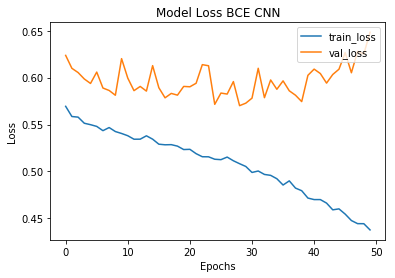

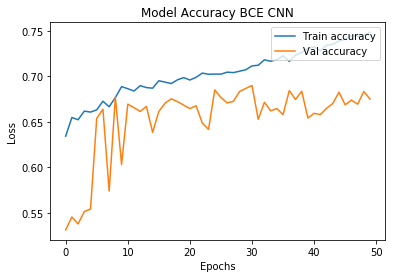

In [21]:
hist=model.fit(x_train, y_train, batch_size=64, epochs=50, verbose=1, class_weight=class_weights, validation_data=(x_val,y_val))
plt.plot(hist.history['loss'],label="train_loss")
plt.plot(hist.history['val_loss'],label="val_loss")
plt.title("Model Loss BCE CNN") 
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(loc="upper right")
plt.show()

plt.plot(hist.history['acc'],label="Train accuracy" )
plt.plot(hist.history['val_acc'],label="Val accuracy" )
plt.title("Model Accuracy BCE CNN") 
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(loc="upper right")
plt.show()

,Precision raw,Recall raw,F1 raw,F1 weighted,F1 macro,F1 micro
False Positive,0.773872,0.705662,0.738195,0.67966,0.654681,0.674879
Confirmed,0.531064,0.617822,0.571167,0.67966,0.654681,0.674879


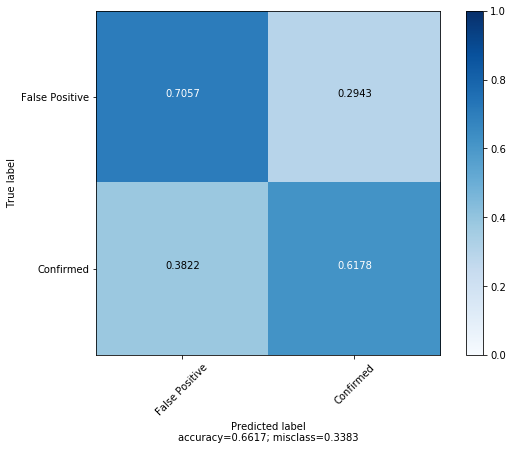

{'Precision raw': array([0.77387229, 0.53106383]), 'Recall raw': array([0.70566239, 0.61782178]), 'F1 raw': array([0.73819503, 0.57116705]), 'F1 weighted': 0.6796598918200301, 'F1 macro': 0.6546810372993236, 'F1 micro': 0.6748785565579458, 'Confusion Matrix': array([[1321,  551],
       [ 386,  624]])}


In [22]:
predichos=model.predict_classes(x_val)
print (calculate_metrics(y_val,predichos,'[VAL] Confusion Matrix 50 epochs CNN + reverse LC'))

Train on 8690 samples, validate on 2882 samples
Epoch 1/50
8690/8690 [==============================] - 3s 360us/step - loss: 0.5722 - acc: 0.6326 - val_loss: 0.6359 - val_acc: 0.5222
Epoch 2/50
8690/8690 [==============================] - 2s 282us/step - loss: 0.5590 - acc: 0.6484 - val_loss: 0.6108 - val_acc: 0.5420
Epoch 3/50
8690/8690 [==============================] - 2s 278us/step - loss: 0.5564 - acc: 0.6554 - val_loss: 0.5958 - val_acc: 0.5465
Epoch 4/50
8690/8690 [==============================] - 2s 276us/step - loss: 0.5556 - acc: 0.6525 - val_loss: 0.5977 - val_acc: 0.5514
Epoch 5/50
8690/8690 [==============================] - 2s 272us/step - loss: 0.5490 - acc: 0.6629 - val_loss: 0.5980 - val_acc: 0.5593
Epoch 6/50
8690/8690 [==============================] - 2s 273us/step - loss: 0.5498 - acc: 0.6594 - val_loss: 0.6047 - val_acc: 0.6489
Epoch 7/50
8690/8690 [==============================] - 2s 272us/step - loss: 0.5449 - acc: 0.6702 - val_loss: 0.5803 - val_acc: 0.6620


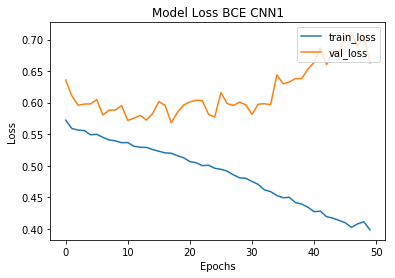

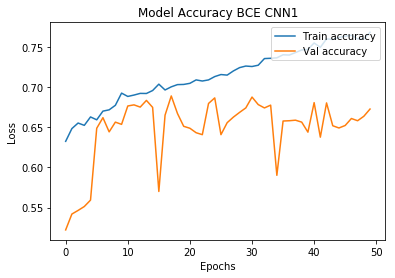

In [23]:
hist1=model1.fit(x_train, y_train, batch_size=64, epochs=50, verbose=1, class_weight=class_weights, validation_data=(x_val,y_val))
plt.plot(hist1.history['loss'],label="train_loss")
plt.plot(hist1.history['val_loss'],label="val_loss")
plt.title("Model Loss BCE CNN1") 
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(loc="upper right")
plt.show()

plt.plot(hist1.history['acc'],label="Train accuracy" )
plt.plot(hist1.history['val_acc'],label="Val accuracy" )
plt.title("Model Accuracy BCE CNN1") 
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(loc="upper right")
plt.show()

,Precision raw,Recall raw,F1 raw,F1 weighted,F1 macro,F1 micro
False Positive,0.726254,0.796474,0.759745,0.664239,0.623483,0.672797
Confirmed,0.540410,0.443564,0.487221,0.664239,0.623483,0.672797


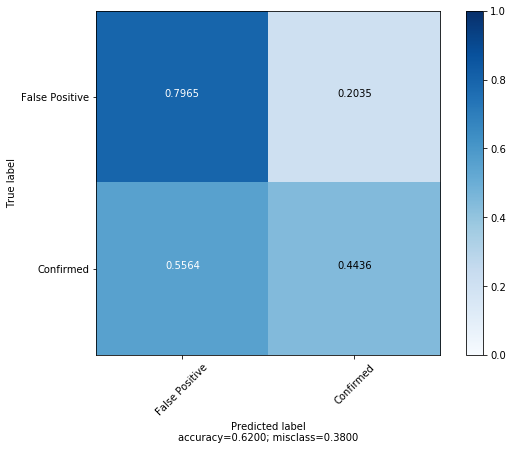

{'Precision raw': array([0.72625426, 0.54041013]), 'Recall raw': array([0.79647436, 0.44356436]), 'F1 raw': array([0.75974522, 0.48722132]), 'F1 weighted': 0.6642389265845727, 'F1 macro': 0.6234832694312542, 'F1 micro': 0.6727966689798751, 'Confusion Matrix': array([[1491,  381],
       [ 562,  448]])}


In [25]:
predichos=model1.predict_classes(x_val)
print (calculate_metrics(y_val,predichos,'[VAL] Confusion Matrix 50 epochs CNN 1 + Reverse LC'))

In [26]:
def focal_loss(gamma=2., weights=1):   #weights np.asarray()
    weights= K.variable(weights)
    def focal_loss_fixed(y_true, y_pred):
        y_true = K.clip(y_true, K.epsilon(),1)
        y_pred = K.clip(y_pred,K.epsilon(),1)
        return - K.sum(weights* K.pow(1. - y_pred, gamma)* y_true * K.log(y_pred), axis=-1) 
    return focal_loss_fixed

In [27]:
model2 = Sequential()
model2.add(Conv2D(64, (3, 3), input_shape=(15,15,1), strides=(1, 1),activation="relu", padding="same"))
model2.add(MaxPooling2D((2,2)))
model2.add(Dropout(0.1))
model2.add(Conv2D(128, (3, 3), strides=(1, 1), activation="relu", padding="same"))
model2.add(Conv2D(256, (3, 3), strides=(1, 1), activation="relu", padding="same"))
#model1.add(Flatten())
model2.add(GlobalAveragePooling2D())
model2.add(Dense(256,activation='relu'))
model2.add(Dropout(0.2))
model2.add(Dense(128, activation='relu'))
model2.add(Dense(2, activation='softmax'))
model2.summary()

model2.compile(loss=focal_loss(2,weights=class_weights),optimizer='adam',metrics=['acc'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 15, 15, 64)        640       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 7, 7, 128)         73856     
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 7, 7, 256)         295168    
_________________________________________________________________
global_average_pooling2d_5 ( (None, 256)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 256)               65792     
__________

In [28]:
y_train_cat=to_categorical(y_train, 2)
y_train_cat[:3]
y_val_cat=to_categorical(y_val, 2)
y_val_cat[:3]

array([[0., 1.],
       [0., 1.],
       [1., 0.]], dtype=float32)

Train on 8690 samples, validate on 2882 samples
Epoch 1/50
8690/8690 [==============================] - 3s 381us/step - loss: 0.1467 - acc: 0.6387 - val_loss: 0.1559 - val_acc: 0.5288
Epoch 2/50
8690/8690 [==============================] - 2s 276us/step - loss: 0.1424 - acc: 0.6472 - val_loss: 0.1566 - val_acc: 0.5357
Epoch 3/50
8690/8690 [==============================] - 2s 276us/step - loss: 0.1430 - acc: 0.6495 - val_loss: 0.1562 - val_acc: 0.5267
Epoch 4/50
8690/8690 [==============================] - 2s 278us/step - loss: 0.1426 - acc: 0.6476 - val_loss: 0.1562 - val_acc: 0.5333
Epoch 5/50
8690/8690 [==============================] - 2s 278us/step - loss: 0.1418 - acc: 0.6516 - val_loss: 0.1586 - val_acc: 0.5350
Epoch 6/50
8690/8690 [==============================] - 2s 276us/step - loss: 0.1420 - acc: 0.6497 - val_loss: 0.1552 - val_acc: 0.5416
Epoch 7/50
8690/8690 [==============================] - 2s 270us/step - loss: 0.1400 - acc: 0.6596 - val_loss: 0.1529 - val_acc: 0.5423


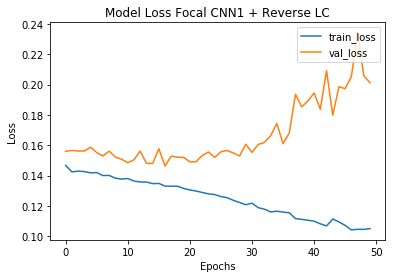

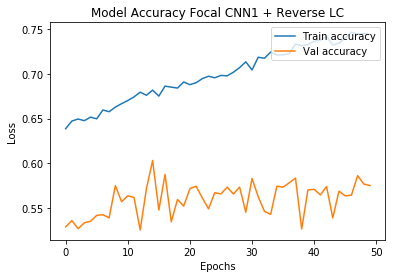

In [29]:
hist2=model2.fit(x_train, y_train_cat, batch_size=64, epochs=50, verbose=1, class_weight=class_weights, validation_data=(x_val,y_val_cat))
plt.plot(hist2.history['loss'],label="train_loss")
plt.plot(hist2.history['val_loss'],label="val_loss")
plt.title("Model Loss Focal CNN1 + Reverse LC") 
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(loc="upper right")
plt.show()

plt.plot(hist2.history['acc'],label="Train accuracy" )
plt.plot(hist2.history['val_acc'],label="Val accuracy" )
plt.title("Model Accuracy Focal CNN1 + Reverse LC") 
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(loc="upper right")
plt.show()

,Precision raw,Recall raw,F1 raw,F1 weighted,F1 macro,F1 micro
False Positive,0.855104,0.416132,0.559828,0.570074,0.574446,0.574948
Confirmed,0.445459,0.869307,0.589064,0.570074,0.574446,0.574948


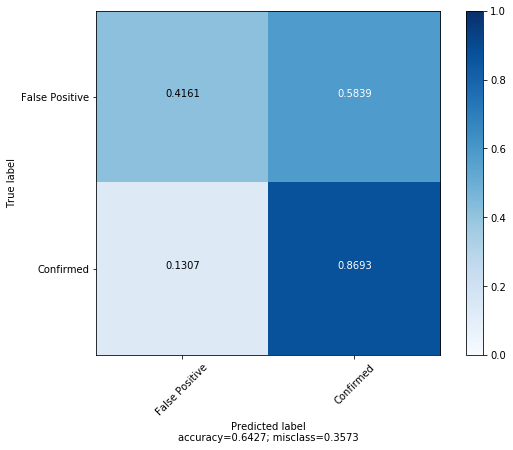

{'Precision raw': array([0.85510428, 0.44545916]), 'Recall raw': array([0.41613248, 0.86930693]), 'F1 raw': array([0.55982752, 0.58906407]), 'F1 weighted': 0.5700735040207271, 'F1 macro': 0.574445798356654, 'F1 micro': 0.5749479528105482, 'Confusion Matrix': array([[ 779, 1093],
       [ 132,  878]])}


In [30]:
predichos=model2.predict_classes(x_val)
print (calculate_metrics(y_val,predichos,'[VAL] Confusion Matrix 50 epochs CNN 1 Focal + Reverse LC'))

# Segundo Modelo

In [31]:
model3 = Sequential()
model3.add(Conv2D(32, (3, 3), input_shape=(15,15,1), strides=(1, 1),activation="relu", padding="same"))
model3.add(Dropout(0.25))
model3.add(Conv2D(32, (3, 3), input_shape=(15,15,1), strides=(1, 1),activation="relu", padding="same"))
model3.add(Dropout(0.15))
model3.add(GlobalAveragePooling2D())
model3.add(Dense(256, activation='relu'))
model3.add(Dropout(0.25))
model3.add(Dense(128,activation='relu'))
model3.add(Dense(1, activation='sigmoid'))
model3.summary()

model3.compile(loss='binary_crossentropy',optimizer='Adam',metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 15, 15, 32)        320       
_________________________________________________________________
dropout_11 (Dropout)         (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 15, 15, 32)        9248      
_________________________________________________________________
dropout_12 (Dropout)         (None, 15, 15, 32)        0         
_________________________________________________________________
global_average_pooling2d_6 ( (None, 32)                0         
_________________________________________________________________
dense_16 (Dense)             (None, 256)               8448      
_________________________________________________________________
dropout_13 (Dropout)         (None, 256)               0         
__________

In [32]:
model4 = Sequential()
model4.add(Conv2D(32, (3, 3), input_shape=(15,15,1), strides=(1, 1),activation="relu", padding="same"))
model4.add(Dropout(0.2))
model4.add(Conv2D(32, (3, 3), input_shape=(15,15,1), strides=(1, 1),activation="relu", padding="same"))
model4.add(Dropout(0.1))
model4.add(GlobalAveragePooling2D())
model4.add(Dense(256, activation='relu'))
model4.add(Dropout(0.2))
model4.add(Dense(128, activation='relu'))
model4.add(Dense(2, activation='softmax'))
model4.summary()
model4.compile(loss=focal_loss(2,weights=class_weights),optimizer='adam',metrics=['acc'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_18 (Conv2D)           (None, 15, 15, 32)        320       
_________________________________________________________________
dropout_14 (Dropout)         (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 15, 15, 32)        9248      
_________________________________________________________________
dropout_15 (Dropout)         (None, 15, 15, 32)        0         
_________________________________________________________________
global_average_pooling2d_7 ( (None, 32)                0         
_________________________________________________________________
dense_19 (Dense)             (None, 256)               8448      
_________________________________________________________________
dropout_16 (Dropout)         (None, 256)               0         
__________

Train on 8690 samples, validate on 2882 samples
Epoch 1/100
8690/8690 [==============================] - 2s 282us/step - loss: 0.5816 - acc: 0.6349 - val_loss: 0.6238 - val_acc: 0.5330
Epoch 2/100
8690/8690 [==============================] - 2s 181us/step - loss: 0.5546 - acc: 0.6574 - val_loss: 0.6103 - val_acc: 0.5420
Epoch 3/100
8690/8690 [==============================] - 2s 180us/step - loss: 0.5519 - acc: 0.6552 - val_loss: 0.6035 - val_acc: 0.5448
Epoch 4/100
8690/8690 [==============================] - 2s 192us/step - loss: 0.5519 - acc: 0.6549 - val_loss: 0.6102 - val_acc: 0.5430
Epoch 5/100
8690/8690 [==============================] - 2s 193us/step - loss: 0.5512 - acc: 0.6574 - val_loss: 0.5971 - val_acc: 0.5534
Epoch 6/100
8690/8690 [==============================] - 2s 198us/step - loss: 0.5505 - acc: 0.6583 - val_loss: 0.5967 - val_acc: 0.5514
Epoch 7/100
8690/8690 [==============================] - 2s 195us/step - loss: 0.5500 - acc: 0.6613 - val_loss: 0.5934 - val_acc: 

8690/8690 [==============================] - 2s 191us/step - loss: 0.5151 - acc: 0.7018 - val_loss: 0.5895 - val_acc: 0.6808
Epoch 61/100
8690/8690 [==============================] - 2s 190us/step - loss: 0.5150 - acc: 0.7026 - val_loss: 0.5904 - val_acc: 0.6853
Epoch 62/100
8690/8690 [==============================] - 2s 187us/step - loss: 0.5165 - acc: 0.7003 - val_loss: 0.5925 - val_acc: 0.6683
Epoch 63/100
8690/8690 [==============================] - 2s 192us/step - loss: 0.5175 - acc: 0.6998 - val_loss: 0.5689 - val_acc: 0.7009
Epoch 64/100
8690/8690 [==============================] - 2s 188us/step - loss: 0.5143 - acc: 0.7023 - val_loss: 0.5867 - val_acc: 0.6634
Epoch 65/100
8690/8690 [==============================] - 2s 187us/step - loss: 0.5159 - acc: 0.7005 - val_loss: 0.5976 - val_acc: 0.6693
Epoch 66/100
8690/8690 [==============================] - 2s 190us/step - loss: 0.5160 - acc: 0.6964 - val_loss: 0.5747 - val_acc: 0.6919
Epoch 67/100
8690/8690 [=======================

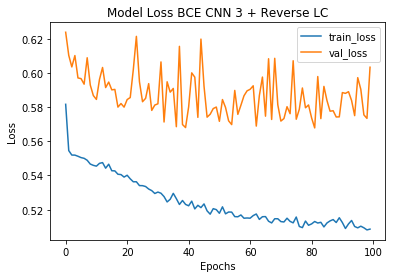

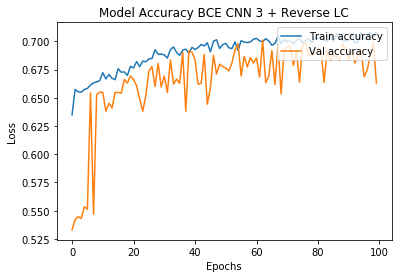

,Precision raw,Recall raw,F1 raw,F1 weighted,F1 macro,F1 micro
False Positive,0.785307,0.662393,0.718632,0.670118,0.649416,0.663081
Confirmed,0.514965,0.664356,0.580199,0.670118,0.649416,0.663081


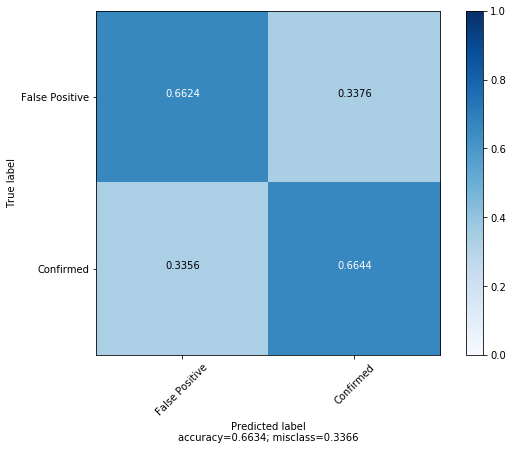

{'Precision raw': array([0.78530716, 0.51496546]), 'Recall raw': array([0.66239316, 0.66435644]), 'F1 raw': array([0.71863228, 0.58019888]), 'F1 weighted': 0.6701181449586828, 'F1 macro': 0.6494155782085632, 'F1 micro': 0.6630811936155447, 'Confusion Matrix': array([[1240,  632],
       [ 339,  671]])}


In [33]:
hist3=model3.fit(x_train, y_train, batch_size=64, epochs=100, verbose=1, class_weight=class_weights, validation_data=(x_val,y_val))
plt.plot(hist3.history['loss'],label="train_loss")
plt.plot(hist3.history['val_loss'],label="val_loss")
plt.title("Model Loss BCE CNN 3 + Reverse LC") 
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(loc="upper right")
plt.show()

plt.plot(hist3.history['acc'],label="Train accuracy" )
plt.plot(hist3.history['val_acc'],label="Val accuracy" )
plt.title("Model Accuracy BCE CNN 3 + Reverse LC") 
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(loc="upper right")
plt.show()

predichos=model3.predict_classes(x_val)
print (calculate_metrics(y_val,predichos,'[VAL] Confusion Matrix 50 epochs CNN 3 BCE + Reverse LC'))

Train on 8690 samples, validate on 2882 samples
Epoch 1/100
8690/8690 [==============================] - 3s 289us/step - loss: 0.1464 - acc: 0.6438 - val_loss: 0.1659 - val_acc: 0.5101
Epoch 2/100
8690/8690 [==============================] - 2s 186us/step - loss: 0.1422 - acc: 0.6455 - val_loss: 0.1557 - val_acc: 0.5278
Epoch 3/100
8690/8690 [==============================] - 2s 192us/step - loss: 0.1421 - acc: 0.6495 - val_loss: 0.1574 - val_acc: 0.5350
Epoch 4/100
8690/8690 [==============================] - 2s 198us/step - loss: 0.1417 - acc: 0.6502 - val_loss: 0.1565 - val_acc: 0.5257
Epoch 5/100
8690/8690 [==============================] - 2s 195us/step - loss: 0.1426 - acc: 0.6476 - val_loss: 0.1589 - val_acc: 0.5239
Epoch 6/100
8690/8690 [==============================] - 2s 193us/step - loss: 0.1413 - acc: 0.6513 - val_loss: 0.1537 - val_acc: 0.5423
Epoch 7/100
8690/8690 [==============================] - 2s 193us/step - loss: 0.1408 - acc: 0.6490 - val_loss: 0.1557 - val_acc: 

8690/8690 [==============================] - 2s 191us/step - loss: 0.1328 - acc: 0.6832 - val_loss: 0.1508 - val_acc: 0.5746
Epoch 61/100
8690/8690 [==============================] - 2s 193us/step - loss: 0.1320 - acc: 0.6848 - val_loss: 0.1477 - val_acc: 0.5749
Epoch 62/100
8690/8690 [==============================] - 2s 194us/step - loss: 0.1321 - acc: 0.6845 - val_loss: 0.1523 - val_acc: 0.5489
Epoch 63/100
8690/8690 [==============================] - 2s 193us/step - loss: 0.1330 - acc: 0.6841 - val_loss: 0.1533 - val_acc: 0.5420
Epoch 64/100
8690/8690 [==============================] - 2s 191us/step - loss: 0.1329 - acc: 0.6829 - val_loss: 0.1504 - val_acc: 0.5597
Epoch 65/100
8690/8690 [==============================] - 2s 196us/step - loss: 0.1319 - acc: 0.6848 - val_loss: 0.1530 - val_acc: 0.5645
Epoch 66/100
8690/8690 [==============================] - 2s 195us/step - loss: 0.1316 - acc: 0.6865 - val_loss: 0.1514 - val_acc: 0.5566
Epoch 67/100
8690/8690 [=======================

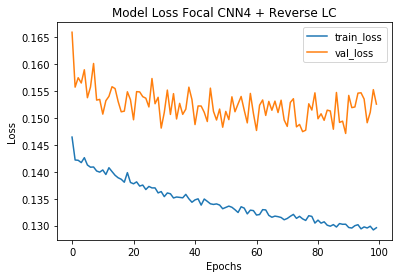

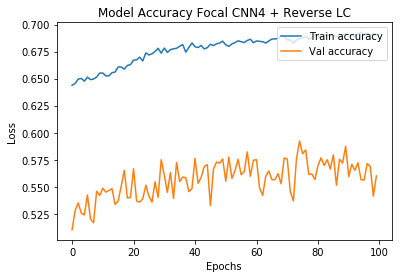

,Precision raw,Recall raw,F1 raw,F1 weighted,F1 macro,F1 micro
False Positive,0.919444,0.353632,0.510802,0.54215,0.555527,0.560028
Confirmed,0.440333,0.942574,0.600252,0.54215,0.555527,0.560028


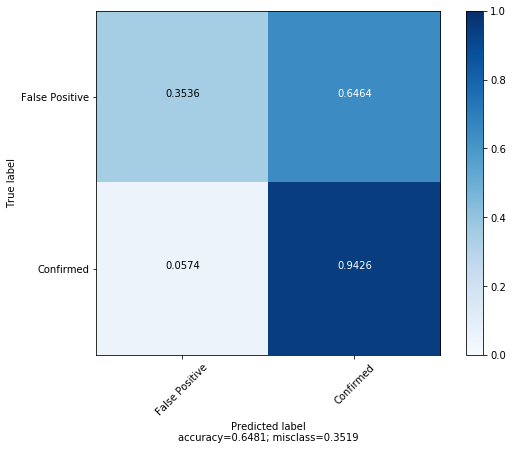

{'Precision raw': array([0.91944444, 0.44033302]), 'Recall raw': array([0.35363248, 0.94257426]), 'F1 raw': array([0.51080247, 0.60025221]), 'F1 weighted': 0.5421502259194664, 'F1 macro': 0.5555273379726932, 'F1 micro': 0.5600277585010409, 'Confusion Matrix': array([[ 662, 1210],
       [  58,  952]])}


In [34]:
hist4=model4.fit(x_train, y_train_cat, batch_size=64, epochs=100, verbose=1, class_weight=class_weights, validation_data=(x_val,y_val_cat))
plt.plot(hist4.history['loss'],label="train_loss")
plt.plot(hist4.history['val_loss'],label="val_loss")
plt.title("Model Loss Focal CNN4 + Reverse LC") 
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(loc="upper right")
plt.show()

plt.plot(hist4.history['acc'],label="Train accuracy" )
plt.plot(hist4.history['val_acc'],label="Val accuracy" )
plt.title("Model Accuracy Focal CNN4 + Reverse LC") 
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(loc="upper right")
plt.show()

predichos=model4.predict_classes(x_val)
print (calculate_metrics(y_val,predichos,'[VAL] Confusion Matrix 50 epochs CNN 1 Focal + Reverse LC'))

Train on 8690 samples, validate on 2882 samples
Epoch 1/50
8690/8690 [==============================] - 1s 122us/step - loss: 0.5024 - acc: 0.7079 - val_loss: 0.5798 - val_acc: 0.6967
Epoch 2/50
8690/8690 [==============================] - 1s 119us/step - loss: 0.5010 - acc: 0.7114 - val_loss: 0.5849 - val_acc: 0.6742
Epoch 3/50
8690/8690 [==============================] - 1s 119us/step - loss: 0.5028 - acc: 0.7112 - val_loss: 0.5947 - val_acc: 0.6783
Epoch 4/50
8690/8690 [==============================] - 1s 122us/step - loss: 0.5017 - acc: 0.7116 - val_loss: 0.5990 - val_acc: 0.6659
Epoch 5/50
8690/8690 [==============================] - 1s 118us/step - loss: 0.5035 - acc: 0.7110 - val_loss: 0.5874 - val_acc: 0.6790
Epoch 6/50
8690/8690 [==============================] - 1s 115us/step - loss: 0.5024 - acc: 0.7086 - val_loss: 0.5800 - val_acc: 0.6908
Epoch 7/50
8690/8690 [==============================] - 1s 115us/step - loss: 0.5018 - acc: 0.7106 - val_loss: 0.5845 - val_acc: 0.6863


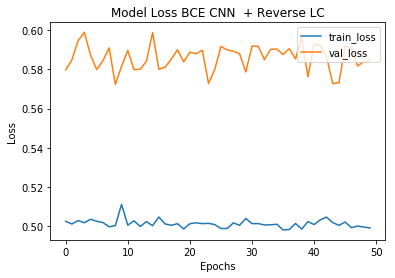

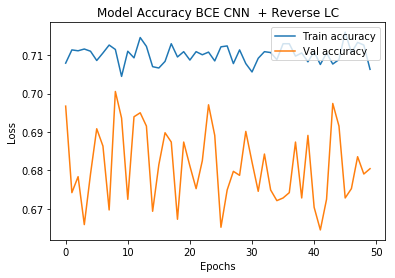

,Precision raw,Recall raw,F1 raw,F1 weighted,F1 macro,F1 micro
False Positive,0.786273,0.697650,0.739315,0.685999,0.663248,0.68043
Confirmed,0.536446,0.648515,0.587181,0.685999,0.663248,0.68043


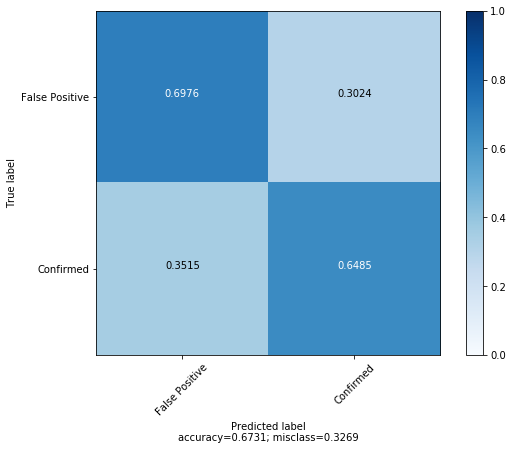

{'Precision raw': array([0.78627333, 0.53644554]), 'Recall raw': array([0.69764957, 0.64851485]), 'F1 raw': array([0.73931503, 0.58718064]), 'F1 weighted': 0.685999367968833, 'F1 macro': 0.6632478331028329, 'F1 micro': 0.6804302567661347, 'Confusion Matrix': array([[1306,  566],
       [ 355,  655]])}


In [37]:
#mini-batches ?
hist3=model3.fit(x_train, y_train, batch_size=256 , epochs=50, verbose=1, class_weight=class_weights, validation_data=(x_val,y_val))
plt.plot(hist3.history['loss'],label="train_loss")
plt.plot(hist3.history['val_loss'],label="val_loss")
plt.title("Model Loss BCE CNN  + Reverse LC") 
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(loc="upper right")
plt.show()

plt.plot(hist3.history['acc'],label="Train accuracy" )
plt.plot(hist3.history['val_acc'],label="Val accuracy" )
plt.title("Model Accuracy BCE CNN  + Reverse LC") 
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(loc="upper right")
plt.show()

predichos=model3.predict_classes(x_val)
print (calculate_metrics(y_val,predichos,'[VAL] Confusion Matrix 50 epochs CNN BCE + Reverse LC'))

,Precision raw,Recall raw,F1 raw,F1 weighted,F1 macro,F1 micro
False Positive,0.762722,0.761386,0.762053,0.718927,0.709299,0.718872
Confirmed,0.655715,0.657376,0.656544,0.718927,0.709299,0.718872


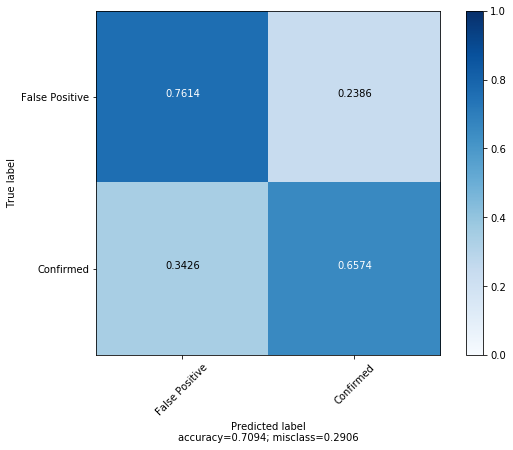

{'Precision raw': array([0.76272178, 0.65571469]), 'Recall raw': array([0.76138575, 0.65737613]), 'F1 raw': array([0.76205318, 0.65654436]), 'F1 weighted': 0.7189269033039225, 'F1 macro': 0.7092987677485754, 'F1 micro': 0.7188722669735328, 'Confusion Matrix': array([[3912, 1226],
       [1217, 2335]])}


In [38]:
predichos=model3.predict_classes(x_train)
print (calculate_metrics(y_train,predichos,'[TRAIN] Confusion Matrix 50 epochs CNN BCE + Reverse LC'))

## modificar completamente los modelos!

In [39]:
model5 = Sequential()
model5.add(Conv2D(16, (3, 3), input_shape=(15,15,1), strides=(1, 1),activation="relu", padding="same"))
model5.add(BatchNormalization())
model5.add(Conv2D(16, (3, 3), input_shape=(15,15,1), strides=(1, 1),activation="relu", padding="same"))
model5.add(BatchNormalization())
model5.add(MaxPooling2D((2,2)))
model5.add(Conv2D(32, (3, 3), input_shape=(15,15,1), strides=(1, 1),activation="relu", padding="same"))
model5.add(BatchNormalization())
model5.add(Conv2D(32, (3, 3), input_shape=(15,15,1), strides=(1, 1),activation="relu", padding="same"))
model5.add(BatchNormalization())
model5.add(GlobalAveragePooling2D())
model5.add(Dropout(0.25))
model5.add(Dense(128, activation='relu'))
model5.add(Dropout(0.25))
model5.add(Dense(2, activation='softmax'))
model5.summary()
model5.compile(loss=focal_loss(2,weights=class_weights),optimizer='adam',metrics=['acc'])

W0814 18:22:20.250283 140515056379712 deprecation_wrapper.py:119] From /users/gmolina/anaconda2/envs/py36/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:1834: The name tf.nn.fused_batch_norm is deprecated. Please use tf.compat.v1.nn.fused_batch_norm instead.



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_20 (Conv2D)           (None, 15, 15, 16)        160       
_________________________________________________________________
batch_normalization_1 (Batch (None, 15, 15, 16)        64        
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 15, 15, 16)        2320      
_________________________________________________________________
batch_normalization_2 (Batch (None, 15, 15, 16)        64        
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 7, 7, 16)          0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 7, 7, 32)          4640      
_________________________________________________________________
batch_normalization_3 (Batch (None, 7, 7, 32)          128       
__________

Train on 8690 samples, validate on 2882 samples
Epoch 1/50
8690/8690 [==============================] - 2s 175us/step - loss: 0.0759 - acc: 0.8392 - val_loss: 0.3268 - val_acc: 0.5947
Epoch 2/50
8690/8690 [==============================] - 1s 171us/step - loss: 0.0778 - acc: 0.8388 - val_loss: 0.3168 - val_acc: 0.5708
Epoch 3/50
8690/8690 [==============================] - 1s 172us/step - loss: 0.0743 - acc: 0.8457 - val_loss: 0.3338 - val_acc: 0.5645
Epoch 4/50
8690/8690 [==============================] - 2s 173us/step - loss: 0.0725 - acc: 0.8542 - val_loss: 0.3130 - val_acc: 0.6034
Epoch 5/50
8690/8690 [==============================] - 2s 174us/step - loss: 0.0708 - acc: 0.8566 - val_loss: 0.4848 - val_acc: 0.6343
Epoch 6/50
8690/8690 [==============================] - 2s 178us/step - loss: 0.0712 - acc: 0.8533 - val_loss: 0.3131 - val_acc: 0.5985
Epoch 7/50
8690/8690 [==============================] - 2s 183us/step - loss: 0.0729 - acc: 0.8559 - val_loss: 0.4180 - val_acc: 0.6190


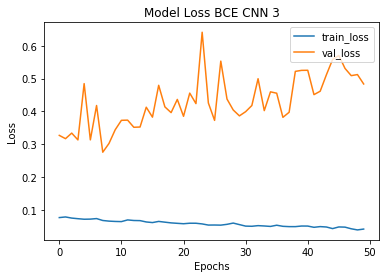

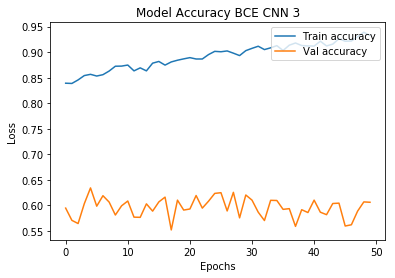

,Precision raw,Recall raw,F1 raw,F1 weighted,F1 macro,F1 micro
False Positive,0.742275,0.603098,0.665488,0.614957,0.593393,0.606176
Confirmed,0.454078,0.611881,0.521299,0.614957,0.593393,0.606176


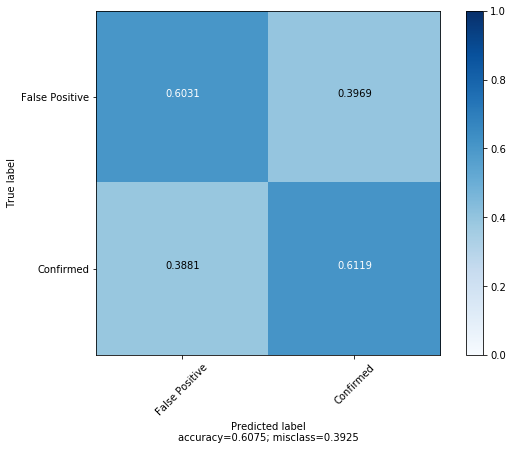

{'Precision raw': array([0.74227482, 0.45407788]), 'Recall raw': array([0.60309829, 0.61188119]), 'F1 raw': array([0.66548777, 0.52129903]), 'F1 weighted': 0.6149566702612417, 'F1 macro': 0.5933933994406078, 'F1 micro': 0.6061762664816099, 'Confusion Matrix': array([[1129,  743],
       [ 392,  618]])}


In [41]:
hist5=model5.fit(x_train, y_train_cat, batch_size=256, epochs=50, verbose=1, class_weight=class_weights, validation_data=(x_val,y_val_cat))
plt.plot(hist5.history['loss'],label="train_loss")
plt.plot(hist5.history['val_loss'],label="val_loss")
plt.title("Model Loss BCE CNN 3") 
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(loc="upper right")
plt.show()
plt.plot(hist5.history['acc'],label="Train accuracy" )
plt.plot(hist5.history['val_acc'],label="Val accuracy" )
plt.title("Model Accuracy BCE CNN 3") 
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(loc="upper right")
plt.show()
predichos=model5.predict_classes(x_val)
print (calculate_metrics(y_val,predichos,'[VAL] Confusion Matrix 100 epochs CNN 5 BCE'))

In [42]:
model6 = Sequential()
model6.add(Conv2D(16, (3, 3), input_shape=(15,15,1), strides=(1, 1),activation="relu", padding="same"))
model6.add(BatchNormalization())
model6.add(Conv2D(16, (3, 3), input_shape=(15,15,1), strides=(1, 1),activation="relu", padding="same"))
model6.add(BatchNormalization())
model6.add(MaxPooling2D((2,2)))

model6.add(Conv2D(32, (3, 3), input_shape=(15,15,1), strides=(1, 1),activation="relu", padding="same"))
model6.add(BatchNormalization())
model6.add(Conv2D(32, (3, 3), input_shape=(15,15,1), strides=(1, 1),activation="relu", padding="same"))
model6.add(BatchNormalization())

model6.add(GlobalAveragePooling2D())
model6.add(Dense(128, activation='relu'))
model6.add(BatchNormalization())
model6.add(Dropout(0.2))
model6.add(Dense(2, activation='softmax'))
model6.summary()
model6.compile(loss=focal_loss(2,weights=class_weights),optimizer='adam',metrics=['acc'])


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_24 (Conv2D)           (None, 15, 15, 16)        160       
_________________________________________________________________
batch_normalization_5 (Batch (None, 15, 15, 16)        64        
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 15, 15, 16)        2320      
_________________________________________________________________
batch_normalization_6 (Batch (None, 15, 15, 16)        64        
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 7, 7, 16)          0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 7, 7, 32)          4640      
_________________________________________________________________
batch_normalization_7 (Batch (None, 7, 7, 32)          128       
__________

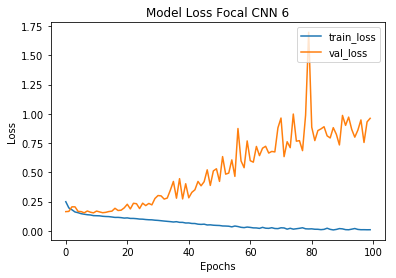

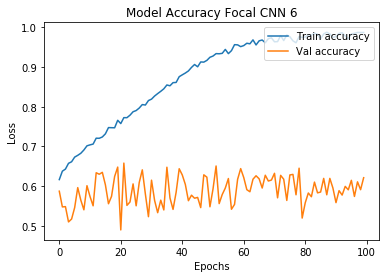

,Precision raw,Recall raw,F1 raw,F1 weighted,F1 macro,F1 micro
False Positive,0.706131,0.713675,0.709883,0.620209,0.581942,0.621096
Confirmed,0.458586,0.449505,0.454000,0.620209,0.581942,0.621096


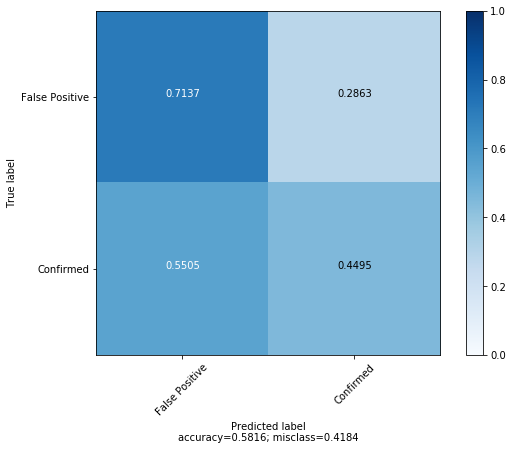

{'Precision raw': array([0.70613108, 0.45858586]), 'Recall raw': array([0.71367521, 0.44950495]), 'F1 raw': array([0.7098831, 0.454    ]), 'F1 weighted': 0.6202085943682101, 'F1 macro': 0.5819415515409139, 'F1 micro': 0.6210964607911172, 'Confusion Matrix': array([[1336,  536],
       [ 556,  454]])}


In [43]:
hist6=model6.fit(x_train, y_train_cat, batch_size=128, epochs=100, verbose=0, class_weight=class_weights, validation_data=(x_val,y_val_cat))
plt.plot(hist6.history['loss'],label="train_loss")
plt.plot(hist6.history['val_loss'],label="val_loss")
plt.title("Model Loss Focal CNN 6") 
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(loc="upper right")
plt.show()

plt.plot(hist6.history['acc'],label="Train accuracy" )
plt.plot(hist6.history['val_acc'],label="Val accuracy" )
plt.title("Model Accuracy Focal CNN 6") 
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(loc="upper right")
plt.show()

predichos=model6.predict_classes(x_val)
print (calculate_metrics(y_val,predichos,'[VAL] Confusion Matrix 100 epochs CNN 6 Focal'))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_28 (Conv2D)           (None, 15, 15, 16)        160       
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 15, 15, 16)        2320      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 7, 7, 16)          0         
_________________________________________________________________
dropout_20 (Dropout)         (None, 7, 7, 16)          0         
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 7, 7, 32)          4640      
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 7, 7, 32)          9248      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 3, 3, 32)          0         
__________

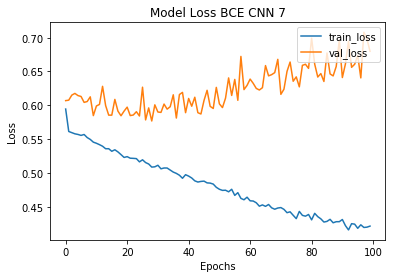

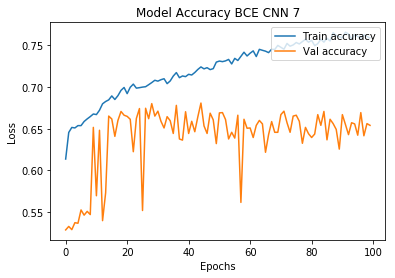

,Precision raw,Recall raw,F1 raw,F1 weighted,F1 macro,F1 micro
False Positive,0.774295,0.659722,0.712431,0.661099,0.639194,0.65406
Confirmed,0.505051,0.643564,0.565956,0.661099,0.639194,0.65406


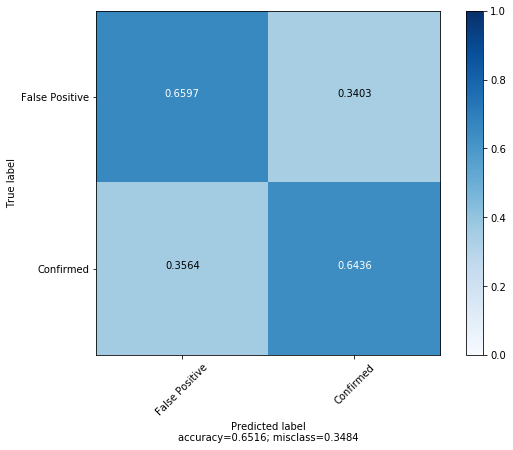

{'Precision raw': array([0.77429467, 0.50505051]), 'Recall raw': array([0.65972222, 0.64356436]), 'F1 raw': array([0.7124315 , 0.56595559]), 'F1 weighted': 0.6610988593082766, 'F1 macro': 0.6391935456124096, 'F1 micro': 0.6540596807772381, 'Confusion Matrix': array([[1235,  637],
       [ 360,  650]])}


In [44]:
model7 = Sequential()
model7.add(Conv2D(16, (3, 3), input_shape=(15,15,1), strides=(1, 1),activation="relu", padding="same"))
model7.add(Conv2D(16, (3, 3), strides=(1, 1), activation="relu", padding="same"))
model7.add(MaxPooling2D((2,2)))
model7.add(Dropout(0.25))

#model7.add(Dropout(0.15))
model7.add(Conv2D(32, (3, 3), strides=(1, 1), activation="relu", padding="same"))
model7.add(Conv2D(32, (3, 3), strides=(1, 1), activation="relu", padding="same"))
model7.add(MaxPooling2D((2,2)))
model7.add(Dropout(0.25))

model7.add(Conv2D(64, (3, 3), strides=(1, 1), activation="relu", padding="same"))
model7.add(Conv2D(64, (3, 3), strides=(1, 1), activation="relu", padding="same"))
#model7.add(MaxPooling2D((2,2)))
model7.add(Dropout(0.25))

model7.add(GlobalAveragePooling2D())
#model7.add(Dropout(0.15))
model7.add(Dense(1, activation='sigmoid'))
model7.summary()

model7.compile(loss='binary_crossentropy',optimizer='adam',metrics=['acc'])

hist7=model7.fit(x_train, y_train, batch_size=128, epochs=100, verbose=0, class_weight=class_weights, validation_data=(x_val,y_val))
plt.plot(hist7.history['loss'],label="train_loss")
plt.plot(hist7.history['val_loss'],label="val_loss")
plt.title("Model Loss BCE CNN 7") 
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(loc="upper right")
plt.show()

plt.plot(hist7.history['acc'],label="Train accuracy" )
plt.plot(hist7.history['val_acc'],label="Val accuracy" )
plt.title("Model Accuracy BCE CNN 7") 
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(loc="upper right")
plt.show()

predichos=model7.predict_classes(x_val)
print (calculate_metrics(y_val,predichos,'[VAL] Confusion Matrix 100 epochs CNN 7 BCE'))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_34 (Conv2D)           (None, 15, 15, 32)        320       
_________________________________________________________________
dropout_23 (Dropout)         (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_35 (Conv2D)           (None, 15, 15, 64)        18496     
_________________________________________________________________
dropout_24 (Dropout)         (None, 15, 15, 64)        0         
_________________________________________________________________
conv2d_36 (Conv2D)           (None, 15, 15, 128)       73856     
_________________________________________________________________
global_average_pooling2d_11  (None, 128)               0         
_________________________________________________________________
dense_27 (Dense)             (None, 256)               33024     
__________

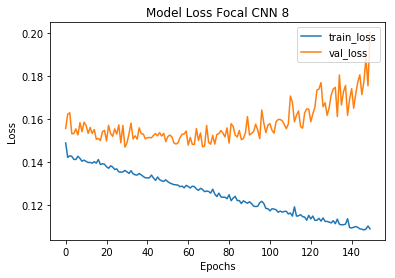

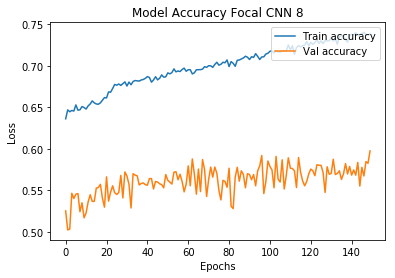

,Precision raw,Recall raw,F1 raw,F1 weighted,F1 macro,F1 micro
False Positive,0.844961,0.465812,0.600551,0.598397,0.597478,0.597502
Confirmed,0.459459,0.841584,0.594406,0.598397,0.597478,0.597502


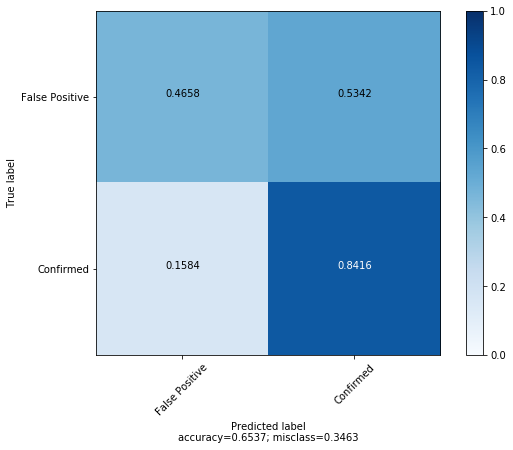

{'Precision raw': array([0.84496124, 0.45945946]), 'Recall raw': array([0.46581197, 0.84158416]), 'F1 raw': array([0.60055096, 0.59440559]), 'F1 weighted': 0.5983973127371021, 'F1 macro': 0.5974782792964611, 'F1 micro': 0.5975017349063151, 'Confusion Matrix': array([[ 872, 1000],
       [ 160,  850]])}


In [45]:
model8 = Sequential()
model8.add(Conv2D(32, (3, 3), input_shape=(15,15,1), strides=(1, 1),activation="relu", padding="same"))
model8.add(Dropout(0.15))
model8.add(Conv2D(64, (3, 3), strides=(1, 1), activation="relu", padding="same"))
model8.add(Dropout(0.15))
model8.add(Conv2D(128, (3, 3), strides=(1, 1), activation="relu", padding="same"))
model8.add(GlobalAveragePooling2D())
model8.add(Dense(256,activation='relu'))
model8.add(Dropout(0.3))
model8.add(Dense(128, activation='relu'))
model8.add(Dropout(0.15))
model8.add(Dense(2, activation='softmax'))
model8.summary()

model8.compile(loss=focal_loss(2,weights=class_weights),optimizer='adam',metrics=['acc'])

hist8=model8.fit(x_train, y_train_cat, batch_size=128, epochs=150, verbose=0, class_weight=class_weights, validation_data=(x_val,y_val_cat))
plt.plot(hist8.history['loss'],label="train_loss")
plt.plot(hist8.history['val_loss'],label="val_loss")
plt.title("Model Loss Focal CNN 8") 
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(loc="upper right")
plt.show()

plt.plot(hist8.history['acc'],label="Train accuracy" )
plt.plot(hist8.history['val_acc'],label="Val accuracy" )
plt.title("Model Accuracy Focal CNN 8") 
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(loc="upper right")
plt.show()

predichos=model8.predict_classes(x_val)
print (calculate_metrics(y_val,predichos,'[VAL] Confusion Matrix 150 epochs CNN 8 Focal'))

In [46]:
x_train.shape

(8690, 15, 15, 1)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 15, 32)            1472      
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 15, 32)            3104      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 7, 32)             0         
_________________________________________________________________
dropout_27 (Dropout)         (None, 7, 32)             0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 7, 64)             6208      
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 7, 64)             12352     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 3, 64)             0         
__________

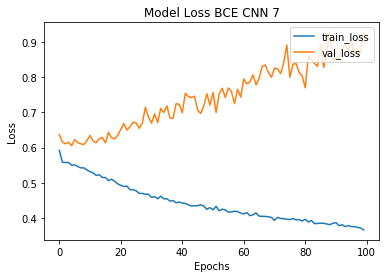

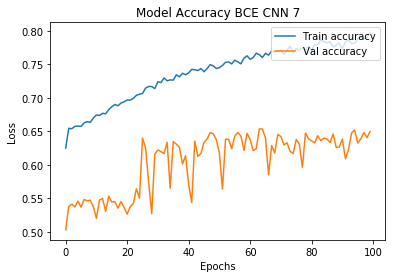

,Precision raw,Recall raw,F1 raw,F1 weighted,F1 macro,F1 micro
False Positive,0.725891,0.739850,0.732804,0.648038,0.611866,0.649549
Confirmed,0.500000,0.482178,0.490927,0.648038,0.611866,0.649549


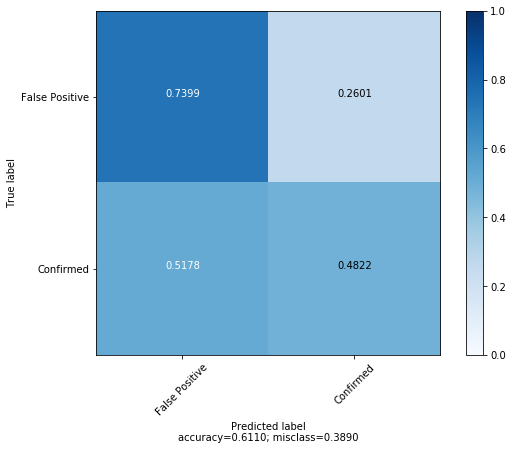

{'Precision raw': array([0.72589099, 0.5       ]), 'Recall raw': array([0.73985043, 0.48217822]), 'F1 raw': array([0.73280423, 0.49092742]), 'F1 weighted': 0.6480382433580537, 'F1 macro': 0.6118658260795358, 'F1 micro': 0.6495489243580846, 'Confusion Matrix': array([[1385,  487],
       [ 523,  487]])}


In [47]:
model9 = Sequential()
model9.add(Conv1D(32, 3, input_shape=(15,15), strides=1,activation="relu", padding="same"))
model9.add(Conv1D(32, 3, strides=1, activation="relu", padding="same"))
model9.add(MaxPooling1D(2))
model9.add(Dropout(0.25))

#model7.add(Dropout(0.15))
model9.add(Conv1D(64, 3, strides=1, activation="relu", padding="same"))
model9.add(Conv1D(64, 3, strides=1, activation="relu", padding="same"))
model9.add(MaxPooling1D(2))
model9.add(Dropout(0.25))

model9.add(Conv1D(128, 3, strides=1, activation="relu", padding="same"))
model9.add(Conv1D(128, 3, strides=1, activation="relu", padding="same"))
#model7.add(MaxPooling2D((2,2)))
model9.add(Dropout(0.25))

model9.add(GlobalAveragePooling1D())
model9.add(Dense(128,activation='relu'))
model9.add(Dropout(0.5))
model9.add(Dense(1, activation='sigmoid'))
model9.summary()

model9.compile(loss='binary_crossentropy',optimizer='adam',metrics=['acc'])

hist9=model9.fit(np.squeeze(x_train), y_train, batch_size=128, epochs=100, verbose=0, class_weight=class_weights, validation_data=(np.squeeze(x_val),y_val))
plt.plot(hist9.history['loss'],label="train_loss")
plt.plot(hist9.history['val_loss'],label="val_loss")
plt.title("Model Loss BCE CNN 7") 
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(loc="upper right")
plt.show()

plt.plot(hist9.history['acc'],label="Train accuracy" )
plt.plot(hist9.history['val_acc'],label="Val accuracy" )
plt.title("Model Accuracy BCE CNN 7") 
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(loc="upper right")
plt.show()

predichos=model9.predict_classes(np.squeeze(x_val))
print (calculate_metrics(y_val,predichos,'[VAL] Confusion Matrix 100 epochs CNN 9 BCE'))